This notebook serves as a continuation of the Crossed Markets Initial Investigation notebook. Following a team member's new data file which includes empty histories and short maturities throughout the trade history, we repeat experiments from the initial notebook and build on those ideas with further experiments. For a general discussion of the crossing markets problem and prior work, refer to Crossed Markets Initial Investigation.ipynb

## Experiment model paths:

1. **Default model**: 'experiments/cross_market/new_ys_experiment_2023-10-16_14:26/model/model_0'

2. **ttype_qty architecture with final dense layers [1]**: 'experiments/cross_market_ttype_qty_architecture/new_ys_experiment_2023-10-17_13:33/model/model_0'

3. **ttype_qty architecture (bottleneck) with final dense layers [1]**: 'experiments/cross_market_ttype_qty_architecture/new_ys_experiment_2023-10-17_15:30/model/model_0'

4. **ttype_qty architecture with final dense layers [25, 1]**: 'experiments/cross_market_ttype_qty_architecture/new_ys_experiment_2023-10-18_13:53/model/model_0'

5. **ttype_qty architecture with final dense layers [50, 25, 1]**: 'experiments/cross_market_ttype_qty_architecture/new_ys_experiment_2023-10-18_22:31/model/model_0'

6. **ttype_qty architecture with removed target ttypes and final dense layers [1]**: 'experiments/cross_market_ttype_qty_architecture_removed_targets/new_ys_experiment_2023-10-18_15:34/model/model_0'

7. **ttype_qty architecture with removed target ttypes and final dense layers [25, 1]**: 'experiments/cross_market_ttype_qty_architecture_removed_targets/new_ys_experiment_2023-10-20_16:41/model/model_0'
 
8. **ttype_qty architecture with removed target ttypes and final dense layers [50, 25, 1]**: 'experiments/cross_market_ttype_qty_architecture_removed_targets/new_ys_experiment_2023-10-20_17:55/model/model_0'

9. **ttype_qty architecture with all ttype features removed and final dense layers [50, 25, 1]**: 'experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-23_13:23/model/model_0'


# Load Packages, Variables

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc
import json
import pytz

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils
# from lgbm_tools import *
from ficc_debiasing import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2023-11-06 17:58:50.131083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 17:58:50.347567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 17:58:50.349254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.7.0


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

train_start = '2023-03-01'
train_end = '2023-08-01'
test_start = '2023-08-01'
test_end = '2023-09-01'

VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0007
BATCH_SIZE = 10000
NUM_EPOCHS = 75 
DROPOUT = 0.1 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
target_variable = 'new_ys' 
trade_history_col = 'trade_history'

In [3]:
print(train_start,
train_end ,
test_start ,
test_end)

2023-03-01 2023-08-01 2023-08-01 2023-09-01


# Load data and basic functions

In [4]:
def load_data_from_pickle(path, bucket = 'isaac_data'):
    if os.path.isfile(path):
        print('File available, loading pickle')
        with open(path, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f'File not available, downloading from cloud storage and saving to {path}')
        fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
        gc_path = os.path.join(bucket, path)
        print(gc_path)
        with fs.open(gc_path) as gf:
            data = pd.read_pickle(gf)
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    return data

In [5]:
# processed_data = load_data_from_pickle('processed_data_2022-9-2023-09.pkl', bucket = 'ficc_training_data_latest')
# additional_trades = load_data_from_pickle('processed_data_historic_yc.pkl', bucket = 'ficc_training_data_latest')

# processed_data = processed_data.set_index('rtrs_control_number').drop(additional_trades.rtrs_control_number, errors ='ignore')
# processed_data = pd.concat([processed_data, additional_trades], ignore_index=True)


# processed_data.sort_values('trade_datetime', inplace=True)
# processed_data.reset_index(drop=True, inplace=True)

# temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
# YS_COLS = get_trade_history_columns()
# processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

# processed_data['last_yield_spread'] = processed_data['last_yield_spread'].fillna(0)
# processed_data['last_seconds_ago'] = processed_data['last_seconds_ago'].fillna(0)

# processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
# processed_data = processed_data.dropna(subset=['trade_history_sum'])
# processed_data.purpose_sub_class.fillna(0, inplace=True)
# processed_data.dropna(subset=['new_ys', 'coupon'], axis=0, inplace=True)

In [6]:
# %%time 
# processed_data = processed_data[processed_data.trade_date>='2023-01-01']
# processed_data.sort_values('trade_datetime', inplace=True)
# processed_data.reset_index(drop=True, inplace=True)

# temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
# YS_COLS = get_trade_history_columns()
# processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

# processed_data['last_yield_spread'] = processed_data['last_yield_spread'].fillna(0)
# processed_data['last_seconds_ago'] = processed_data['last_seconds_ago'].fillna(0)

# processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
# processed_data = processed_data.dropna(subset=['trade_history_sum'])
# processed_data.purpose_sub_class.fillna(0, inplace=True)
# processed_data.dropna(subset=['new_ys', 'coupon', 'issue_amount'], axis=0, inplace=True)

# processed_data.to_pickle('working_dataset.pkl')

In [7]:
# processed_data.to_pickle('working_dataset.pkl')

In [8]:
processed_data = pd.read_pickle('working_dataset.pkl')

In [9]:
# processed_data = load_data_from_pickle('working_data_2023-01-2023-09', bucket = 'isaac_data')

In [10]:
def modify_features(cols, how, where=None):
    global CATEGORICAL_FEATURES, PREDICTORS, NON_CAT_FEATURES, BINARY
    
    if how not in ['add','remove']:
        raise ValueError("'how' argument must be one off the following: ['add','remove']")
        
    if where not in ['categorical','binary', 'numeric']:
        raise ValueError("'where' argument must be one off the following: ['categorical','binary', 'numeric']")
    
    if not isinstance(cols, list):
        raise TypeError(f"'cols' argument must be a list, received {type(cols)}")
    
        
    if how == 'remove':
        for col in cols: 
            if col in CATEGORICAL_FEATURES:
                CATEGORICAL_FEATURES.remove(col)
            if col in BINARY:
                BINARY.remove(col)
            if col in NON_CAT_FEATURES:
                NON_CAT_FEATURES.remove(col)
            if col in PREDICTORS:
                PREDICTORS.remove(col)
            
    if how == 'add':
        for col in cols: 
            if col not in CATEGORICAL_FEATURES and where=='categorical':
                CATEGORICAL_FEATURES.append(col)
            if col not in BINARY and where=='binary':
                BINARY.append(col)
            if col not in NON_CAT_FEATURES and where=='numeric':
                NON_CAT_FEATURES.append(col)
            if col not in PREDICTORS:
                PREDICTORS.append(col)

In [11]:
# fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
# with fs.open('gs://automated_training/encoders.pkl', 'rb') as gf:
#     encoders = pickle.load(gf)

with open('encoders.pkl', 'rb') as f: 
    encoders = pickle.load(f)
    
fmax = {key: len(value.classes_) for key, value in encoders.items()}

In [12]:
# nans = processed_data[BINARY+CATEGORICAL_FEATURES+NON_CAT_FEATURES+[trade_history_col, 'target_attention_features', target_variable]].isna().sum()
# nans[nans>0]

# Model and Data Preparation Code

In [13]:
BINARY = ['callable',
          'sinking',
          'zerocoupon',
          'is_non_transaction_based_compensation',
          'is_general_obligation',
          'callable_at_cav',
          'extraordinary_make_whole_call',
          'make_whole_call',
          'has_unexpired_lines_of_credit',
          'escrow_exists']

CATEGORICAL_FEATURES = ['rating',
                        'incorporated_state_code',
                        'trade_type',
                        'purpose_class',
                        'max_ys_ttypes',
                        'min_ys_ttypes',
                        'max_qty_ttypes',
                        'min_ago_ttypes',
                        'D_min_ago_ttypes',
                        'P_min_ago_ttypes',
                        'S_min_ago_ttypes']

NON_CAT_FEATURES = ['quantity',
                    'days_to_maturity',
                     'days_to_call',
                     'coupon',
                     'issue_amount',
                     'last_seconds_ago',
                     'last_yield_spread',
                     'days_to_settle',
                     'days_to_par',
                     'maturity_amount',
                     'issue_price',
                     'orig_principal_amount',
                     'max_amount_outstanding',
                     'accrued_days',
                     'days_in_interest_payment',
                     'A/E',
                     'ficc_treasury_spread',
                     'max_ys_ys',
                     'max_ys_ago',
                     'max_ys_qdiff',
                     'min_ys_ys',
                     'min_ys_ago',
                     'min_ys_qdiff',
                     'max_qty_ys',
                     'max_qty_ago',
                     'max_qty_qdiff',
                     'min_ago_ys',
                     'min_ago_ago',
                     'min_ago_qdiff',
                     'D_min_ago_ys',
                     'D_min_ago_ago',
                     'D_min_ago_qdiff',
                     'P_min_ago_ys',
                     'P_min_ago_ago',
                     'P_min_ago_qdiff',
                     'S_min_ago_ys',
                     'S_min_ago_ago',
                     'S_min_ago_qdiff']


def reset_model_features():
    '''Function resets the model features, which are global variables, to their original state for convenience when running new architectures'''
    global NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES
    
    BINARY = ['callable',
          'sinking',
          'zerocoupon',
          'is_non_transaction_based_compensation',
          'is_general_obligation',
          'callable_at_cav',
          'extraordinary_make_whole_call',
          'make_whole_call',
          'has_unexpired_lines_of_credit',
          'escrow_exists']

    CATEGORICAL_FEATURES = ['rating',
                            'incorporated_state_code',
                            'trade_type',
                            'purpose_class',
                            'max_ys_ttypes',
                            'min_ys_ttypes',
                            'max_qty_ttypes',
                            'min_ago_ttypes',
                            'D_min_ago_ttypes',
                            'P_min_ago_ttypes',
                            'S_min_ago_ttypes']

    NON_CAT_FEATURES = ['quantity',
                        'days_to_maturity',
                         'days_to_call',
                         'coupon',
                         'issue_amount',
                         'last_seconds_ago',
                         'last_yield_spread',
                         'days_to_settle',
                         'days_to_par',
                         'maturity_amount',
                         'issue_price',
                         'orig_principal_amount',
                         'max_amount_outstanding',
                         'accrued_days',
                         'days_in_interest_payment',
                         'A/E',
                         'ficc_treasury_spread',
                         'max_ys_ys',
                         'max_ys_ago',
                         'max_ys_qdiff',
                         'min_ys_ys',
                         'min_ys_ago',
                         'min_ys_qdiff',
                         'max_qty_ys',
                         'max_qty_ago',
                         'max_qty_qdiff',
                         'min_ago_ys',
                         'min_ago_ago',
                         'min_ago_qdiff',
                         'D_min_ago_ys',
                         'D_min_ago_ago',
                         'D_min_ago_qdiff',
                         'P_min_ago_ys',
                         'P_min_ago_ago',
                         'P_min_ago_qdiff',
                         'S_min_ago_ys',
                         'S_min_ago_ago',
                         'S_min_ago_qdiff']

In [14]:
#MODEL AND DATA FUNCTIONS
def create_input(df, trade_history_col):
    global encoders
    datalist = []
        
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float64'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[0]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f],
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())
    
    return model
    

def generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[0]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
    trade_history_output = layers.Dense(1)(trade_history_output)
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f],
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(300,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_hidden3 = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    reference_hidden3 = layers.BatchNormalization()(reference_hidden3)
    reference_hidden3 = layers.Dropout(DROPOUT)(reference_hidden3)
    
    reference_output = layers.Dense(1, name='reference_output')(reference_hidden3)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    final = layers.Dense(1)(feed_forward_input)

    model = keras.Model(inputs=inputs, outputs=final)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())
    
    return model

def generate_model_ensemble(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer, ensemble_size):
    models = []
    for i in range(ensemble_size):
        if i < ensemble_size/2:
            models.append(generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer))
        else:
            models.append(generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer))
            
    input_layer = models[0].input
    output_list = [model(input_layer) for model in models]
    ensemble_model = keras.Model(inputs = input_layer, outputs = output_list)
    ensemble_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                 loss=[keras.losses.MeanAbsoluteError() for i in range(ensemble_size)])

    return ensemble_model

def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH}
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input(train_dataframe.drop(val_idx, axis=0), trade_history_col)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input(train_dataframe.iloc[val_idx], trade_history_col)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input(test_dataframe, trade_history_col)
    y_test = test_dataframe[target_variable]    
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx


def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

def train_model(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    
    if model_to_use == 'default':
        model = generate_model_default(TRADE_SEQUENCE_LENGTH,trade_history_normalizer, noncat_binary_normalizer)
        
    elif model_to_use=='bottleneck': 
        model = generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer)
        
    elif model_to_use=='ensemble': 
        model = generate_model_ensemble(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer, ensemble_size)
    
    else:
        raise ValueError(f'Invalid model specified, {model_to_use}')
        
        
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        ]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model

In [15]:
def log_experiment(experiment_dir, parameters, model):
    if not os.path.isdir(experiment_dir):
        print(f'{experiment_dir} does not exist. Creating now')
        os.makedirs(experiment_dir)
    
    if not os.path.isdir(os.path.join(experiment_dir, 'model')):
        os.makedirs(os.path.join(experiment_dir, 'model'))
    
    parameters_path = os.path.join(experiment_dir, 'parameters.json')
    
    with open(parameters_path, 'w') as metadata_file:
        json.dump(parameters, metadata_file)

    i = 0
    model_path = f'model/model_{i}'
    while os.path.isdir(os.path.join(experiment_dir, model_path)):
        i+=1
        model_path = f'model/model_{i}'
    model.save(os.path.join(experiment_dir, model_path))
    print(f'Model saved to {os.path.join(experiment_dir, model_path)}')
    
def run_experiment(n_runs, experiment_prefix = None):
    tz=pytz.timezone('US/Pacific')
    timestamp = datetime.now(tz).strftime("%Y-%m-%d_%H:%M")
    results = []
    predictions = []
    
    if experiment_prefix:
        experiment_dir = f'experiments/{experiment_prefix}/{target_variable}_experiment_{timestamp}'
    else:
        experiment_dir = f'experiments/{target_variable}_experiment_{timestamp}'

    parameters = {'train_start':train_start,
                    'train_end':train_end,
                    'test_start':test_start,
                    'test_end':test_end,
                    'train_size':len(train_dataframe),
                    'test_size':len(test_dataframe),
                    'VALIDATION_SPLIT':VALIDATION_SPLIT,
                    'LEARNING_RATE':LEARNING_RATE,
                    'BATCH_SIZE':BATCH_SIZE,
                    'NUM_EPOCHS':NUM_EPOCHS,
                    'DROPOUT':DROPOUT,
                    'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH,
                    'NUM_FEATURES':NUM_FEATURES,
                    'target_variable':target_variable,
                    'features':BINARY+NON_CAT_FEATURES+CATEGORICAL_FEATURES,
                    'shuffle_buffer':shuffle_buffer,
                    'use_bottleneck_model':use_bottleneck_model}
 
    print(f'Experiment results will be saved to {experiment_dir}\n')
    print(f'Performing {n_runs} runs with parameters: {parameters}')
    for i in range(n_runs):
        tf.keras.utils.set_random_seed(10)
        history, model = train_model(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = shuffle_buffer)
        pred = model.predict(x_test, batch_size=10000)
        predictions.append(pred)
        print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
        results.append([history, model])
        log_experiment(experiment_dir, parameters, model)
    
    with open(os.path.join(experiment_dir, 'predictions.pkl'), 'wb') as f: 
        pickle.dump(predictions, f)
        
    with open(os.path.join(experiment_dir, 'results.pkl'), 'wb') as f: 
        pickle.dump([x[0] for x in results], f)
        
    return results


def addflag(flag, condition, name):
    empty = flag == "none"
    flag[condition & empty] = name
    flag[condition & ~empty] = flag[condition & ~empty] + " & " + name
    
def addcol(data, newname, newvals, warn=False):
    if newname in data.columns:
        if warn: print( f"Warning: replacing duplicate column {newname}" )
        data[newname] = newvals
    else:
        newcol = pd.Series(newvals, index = data.index, name=newname)
        data = pd.concat([data,newcol],axis=1)
    return data

def mkcases(df):
    flag = pd.Series("none", index=df.index)

    addflag(flag, df.last_yield.isna(), "no last yld")
    addflag(flag, df.last_yield < 150, "last yld < 1.5%")
    addflag(flag, df.last_yield.between(150,700), "1.5% <= last yld <= 7%")
    addflag(flag, df.last_yield > 700, "last yld > 7%")
    addflag(flag, df.when_issued, "when issued")
    
    print( flag.value_counts(dropna=False) )
    return flag.astype('category')

def mean_absolute_deviation(pred, truth):
    pred, truth = np.array(pred).reshape(-1,1), np.array(truth).reshape(-1,1)
    err = abs(pred - truth)
    return np.median(err)

def compare_mae(df, prediction_cols, groupby_cols, target_variable):
    
    if not isinstance(prediction_cols, list):
        raise TypeError(f'prediction_cols must be a list, got {type(prediction_cols)}, {type(groupby_cols)} instead')
    
    if groupby_cols and not isinstance(groupby_cols, list):
        raise TypeError(f'groupby_cols must be a list or None, got {type(groupby_cols)} instead')
    
    print(f'{f" Analysis for target: {target_variable} ":=^75}')
    
    nan_counts = df[prediction_cols].isna().sum() 
    
    for x,y  in df[prediction_cols].isna().sum().iteritems():
        print(f'Prediction col {x} has {y} nan values')
    
    df = df.dropna(subset=prediction_cols)

    if groupby_cols:
        temp = df[[target_variable, 'cases'] + prediction_cols + groupby_cols]\
                .groupby(groupby_cols, observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp = pd.DataFrame(temp.to_list(), index = zip(['Overall']*len(temp),temp.index))

        temp2 = df[[target_variable, 'cases'] + prediction_cols + groupby_cols]\
                .groupby(['cases']+ groupby_cols, observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp2 = pd.DataFrame(temp2.to_list(), index = temp2.index)
        summary = pd.concat([temp, temp2], axis=0)

    else:
        
        temp2 = df[[target_variable, 'cases'] + prediction_cols]\
                .groupby('cases', observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp2 = pd.DataFrame(temp2.to_list(), index = temp2.index)
        
        temp = pd.DataFrame([mean_absolute_error(df[target_variable], df[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(df[target_variable], df[col]) for col in prediction_cols] + [len(df)], columns=['Overall']).T
    
    summary = pd.concat([temp, temp2], axis=0)  
    mae_col = ['MAE']*len(prediction_cols)
    mad_col = ['MAD']*len(prediction_cols)
    columns= list(zip(mae_col, prediction_cols)) + list(zip(mad_col, prediction_cols)) + [('', 'N')]
    summary.columns=pd.MultiIndex.from_tuples(columns)
    
    if groupby_cols:
        summary.index=pd.MultiIndex.from_tuples(summary.index, names = ['cases']+groupby_cols)
    else:
        pass
    
    summary[('', 'N')] = summary[('', 'N')].astype(int)
    return summary

In [16]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)

In [17]:
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

train_dataframe['last_seconds_ago'] = train_dataframe['last_seconds_ago'].fillna(0)
train_dataframe['last_yield_spread'] = train_dataframe['last_yield_spread'].fillna(0)

test_dataframe['last_seconds_ago'] = test_dataframe['last_seconds_ago'].fillna(0)
test_dataframe['last_yield_spread'] = test_dataframe['last_yield_spread'].fillna(0)

# test_dataframe = test_dataframe.

In [18]:
short_filter = ((test_dataframe.days_to_call == 0) | (test_dataframe.days_to_call > np.log10(400))) & \
            ((test_dataframe.days_to_maturity == 0) | (test_dataframe.days_to_maturity > np.log10(400))) & \
            ((test_dataframe.days_to_refund == 0) | (test_dataframe.days_to_refund > np.log10(400))) & \
            (test_dataframe.days_to_maturity < np.log10(30000))  

In [19]:
test_dataframe = addcol(test_dataframe, 'cases', mkcases(test_dataframe))

1.5% <= last yld <= 7%                  866005
1.5% <= last yld <= 7% & when issued     53088
no last yld & when issued                24258
last yld < 1.5%                           5937
no last yld                               5082
last yld > 7%                             2877
last yld > 7% & when issued                138
dtype: int64


# 1: Default Model
This is the default architecture - what is used in production.

In [20]:
reset_model_features()
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)

TRAINING DATA: N = 3768210, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
VALIDATION DATA: N = 418690, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
TEST DATA: N = 957385, MIN DATE = 2023-08-01 00:00:00, MAX DATE = 2023-08-31 00:00:00


2023-11-06 18:05:28.303104: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 18:05:28.329539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 18:05:28.333071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 18:05:28.335608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [23]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

14
(3768210, 5, 6)
(3768210, 1, 3)
(3768210, 48)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)


In [24]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment(5, experiment_prefix='cross_market')

Experiment results will be saved to experiments/cross_market/new_ys_experiment_2023-11-03_15:59

Performing 5 runs with parameters: {'train_start': '2023-03-01', 'train_end': '2023-08-01', 'test_start': '2023-08-01', 'test_end': '2023-09-01', 'train_size': 4186900, 'test_size': 957385, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quantity', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 'A/E', 'ficc_trea

2023-11-03 22:59:30.673614: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-03 22:59:41.380906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 549648 of 2826157
2023-11-03 22:59:51.380900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1104576 of 2826157
2023-11-03 2

377/377 [==============================] - ETA: 0s - loss: 42.3966

2023-11-03 23:02:38.771962: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


377/377 [==============================] - 204s 346ms/step - loss: 42.3966 - val_loss: 35.4470
Epoch 2/150
377/377 [==============================] - 29s 78ms/step - loss: 21.1244 - val_loss: 15.2031
Epoch 3/150
377/377 [==============================] - 29s 76ms/step - loss: 14.3556 - val_loss: 13.3313
Epoch 4/150
377/377 [==============================] - 30s 80ms/step - loss: 13.9184 - val_loss: 13.2098
Epoch 5/150
377/377 [==============================] - 29s 76ms/step - loss: 13.6919 - val_loss: 12.9881
Epoch 6/150
377/377 [==============================] - 31s 83ms/step - loss: 13.5380 - val_loss: 12.8680
Epoch 7/150
377/377 [==============================] - 29s 76ms/step - loss: 13.4203 - val_loss: 12.7014
Epoch 8/150
377/377 [==============================] - 30s 80ms/step - loss: 13.3112 - val_loss: 12.7114
Epoch 9/150
377/377 [==============================] - 29s 76ms/step - loss: 13.2321 - val_loss: 12.5506
Epoch 10/150
377/377 [==============================] - 31s 82ms/

KeyboardInterrupt: 

In [25]:
default_model = keras.models.load_model('experiments/cross_market/new_ys_experiment_2023-10-16_14:26/model/model_0')
test_dataframe['prediction_1'] = default_model.predict(x_test, batch_size=10000)

2023-11-03 23:14:01.314075: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [ ]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction_1'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction_1'],   
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

## Checking cross predictions

In [21]:
from ficc.pricing.price import compute_price
from ficc.utils.auxiliary_variables import COUPON_FREQUENCY_TYPE 


def invert_attention(arr):
    '''Inverts target_attention_features column by flipping the trade type (indexed col 1 and 2) since those are target trade dependent'''
    return arr[:, [0,2,1]]

def reverse_direction_concat(df):
        '''
        Copies a dataframe, inverts trade_type dependent features for 'S' and 'P' trades and concatenates the new trades to the dataframe.

        Multiple calls to process_data() would be highly inefficient, we minimize repeated computations/data retrievals by just changing target trade dependent features like ttypes and target_attention_features.
        This is a column-wise pandas operation which should, in theory, be much faster than calling process_data again. 
        Memory consumption should be the same, if not better, than multiple calls to process_data, since the function call stack and intermediate memory used by process_data might be more.
        '''

        #if df empty, exit
        if not len(df):
            return df

        ttype_features = [
            'max_ys_ttypes',
            'min_ys_ttypes',
            'max_dp_ttypes',
            'min_dp_ttypes',
            'max_qty_ttypes',
            'min_ago_ttypes',
            'D_min_ago_ttypes',
            'P_min_ago_ttypes',
            'S_min_ago_ttypes',
            'trade_type'
            ]   
        df_cols = set(df.columns)
        temp = df.copy()

        if 'original_trade' in df_cols:
            temp['original_trade'] = False

        flip = {'P':'S', 'S':'P'}
        
        for col in ttype_features:
            if col not in df_cols:
                continue
            elif col =='trade_type':
                #trade_type is inverted by just flipping the first character
                target_trade_type= temp[col].iloc[0]
                temp[col] =  temp[col].apply(flip.get)
            else:
                #trade history derived ttype is inverted by flipping the second character
                temp[col] =  temp[col].str[0] + temp[col].str[1].apply(flip.get)

        temp['target_attention_features'] = temp['target_attention_features'].parallel_apply(invert_attention)
        #for single cusip pricing, it is convenient if the order is consistent (e.g first row S, second row P)
        #for batch pricing this does not matter, we handle differently anyway
        if target_trade_type == 'S':
            return pd.concat([df, temp], ignore_index=True)
        else: 
            return pd.concat([temp, df], ignore_index=True) 

def check_cross(df, price_col):
    #Checks whether prices cross, returning boolean 
    P_price = df[df.trade_type=='P'][price_col].values[0]
    S_price = df[df.trade_type=='S'][price_col].values[0]

    return P_price > S_price

def check_cross_diff(df, price_col):
    #Checks whether prices cross, returning difference
    P_price = df[df.trade_type=='P'][price_col].values[0]
    S_price = df[df.trade_type=='S'][price_col].values[0]

    return S_price - P_price

def check_cross_diff_fast(df, col):
    #Significantly faster operation to check for crossing that uses pivot tables rather than dataframe slicing + pandas groupby. No longer requires pandarellel, which is problematic when called many times (why?)
    
    temp = pd.pivot_table(df[['id', 'trade_type', col]], values = [col], index='id', columns='trade_type')\
            .droplevel(0, axis=1)\
            [['P','S']]\
            .diff(axis=1)\
            .iloc[:, 1]\
            # .reset_index()
    return temp

In [37]:
cross_df = test_dataframe[(test_dataframe.trade_type!='D') & (test_dataframe.trade_date<='2023-08-15')]
cross_df['id'] = range(len(cross_df))
cross_df = reverse_direction_concat(cross_df)

#interest_payment_frequency is needed as a categorical to make calculate price
cross_df['interest_payment_frequency_str'] = cross_df['interest_payment_frequency'].values
cross_df['interest_payment_frequency'] = cross_df['interest_payment_frequency'].parallel_apply(lambda x: COUPON_FREQUENCY_TYPE[x])

print(len(cross_df))

586988


In [23]:
cross_df.id.value_counts().value_counts()

2    293494
Name: id, dtype: int64

In [287]:
#checking to see that the inverted trade is correctly processed
cross_df[cross_df.id==0][['trade_type', 'target_attention_features']+[x for x in CATEGORICAL_FEATURES if 'ttypes' in x]]

,trade_type,target_attention_features,max_ys_ttypes,min_ys_ttypes,max_qty_ttypes,min_ago_ttypes,D_min_ago_ttypes,P_min_ago_ttypes,S_min_ago_ttypes
0,S,"[[4.301030158996582, 0.0, 1.0]]",PS,SS,DS,DS,DS,PS,SS
293494,P,"[[4.301030158996582, 1.0, 0.0]]",PP,SP,DP,DP,DP,PP,SP


In [ ]:
saved_predictions = pd.read_pickle('saved_predictions.pkl').drop('rtrs_control_number', axis=1)
cross_df = pd.concat([cross_df, saved_predictions], axis = 1)

In [24]:
default_model = keras.models.load_model('experiments/cross_market/new_ys_experiment_2023-10-16_14:26/model/model_0')

In [25]:
tf.keras.backend.clear_session()
gc.collect()

14888

In [81]:
%%time
x_cross = create_input(cross_df, trade_history_col)

preds = default_model.predict(x_cross , batch_size=10000)
cross_df['predicted_ytw_1'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100
cross_df['predicted_dp_1'], cross_df['predicted_calc_date_1'] = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_1']), axis = 1))

%time diffs = check_cross_diff_fast(cross_df, 'predicted_dp_1').to_dict()
%time cross_df['crossdiff_1'] = cross_df['id'].parallel_apply(diffs.get)

%time diffs = check_cross_diff_fast(cross_df, 'predicted_ytw_1').to_dict()
%time cross_df['crossdiff_ytw_1'] = cross_df['id'].parallel_apply(diffs.get)

CPU times: user 3.81 s, sys: 22.3 ms, total: 3.83 s
Wall time: 3.85 s
CPU times: user 11.5 s, sys: 3.68 s, total: 15.2 s
Wall time: 15.9 s
CPU times: user 1.73 s, sys: 16.9 ms, total: 1.74 s
Wall time: 1.74 s
CPU times: user 11.3 s, sys: 3.47 s, total: 14.8 s
Wall time: 15.5 s
CPU times: user 46.9 s, sys: 14.2 s, total: 1min 1s
Wall time: 2min 8s


## A small investigation: crossing is not symmetrical

Crossing does not happen at the same frequency when we are using ytw compared to dollar price. This is a short investigation on why that is the case:
1. price crossing is a subset of ytw crossing 
2. when ytw crosses but price does not cross, it is because even though predicted ytw is different, converted price is the same, presumably due to rounding somewhere in the optimization process

In [82]:
(cross_df['crossdiff_1']<0).sum()

14602

In [83]:
(cross_df['crossdiff_ytw_1']>0).sum()

14754

In [84]:
X1 = (cross_df['crossdiff_1']<0)
X2 = (cross_df['crossdiff_ytw_1']>0)

In [89]:
sum(X1 & X2), sum(X1 & ~X2), sum(~X1 & X2)

(14602, 0, 152)

In [90]:
X2_not_X1 = cross_df[~X1 & X2]
X2_not_X1_id = X2_not_X1['id'].unique()
for i in range(10):
    display(X2_not_X1[X2_not_X1['id'] == X2_not_X1_id[i]][['cusip', 'coupon', 'quantity', 'interest_payment_frequency', 'next_call_date', 'maturity_date', 'is_callable', 'trade_type', 'yield', 'dollar_price', 'predicted_ytw_1','predicted_dp_1', 'predicted_calc_date_1']].sort_values('trade_type', ascending=False))

,cusip,coupon,quantity,interest_payment_frequency,next_call_date,maturity_date,is_callable,trade_type,yield,dollar_price,predicted_ytw_1,predicted_dp_1,predicted_calc_date_1
4175,57582PAD2,5.250,6.602,2,NaT,2023-09-01,False,S,320.700,100.153,3.405,100.137,2023-09-01
297669,57582PAD2,5.250,6.602,2,NaT,2023-09-01,False,P,320.700,100.153,3.405,100.137,2023-09-01


,cusip,coupon,quantity,interest_payment_frequency,next_call_date,maturity_date,is_callable,trade_type,yield,dollar_price,predicted_ytw_1,predicted_dp_1,predicted_calc_date_1
298067,57582PAD2,5.250,6.851,2,NaT,2023-09-01,False,S,330.800,100.145,3.642,100.118,2023-09-01
4573,57582PAD2,5.250,6.851,2,NaT,2023-09-01,False,P,330.800,100.145,3.638,100.118,2023-09-01


,cusip,coupon,quantity,interest_payment_frequency,next_call_date,maturity_date,is_callable,trade_type,yield,dollar_price,predicted_ytw_1,predicted_dp_1,predicted_calc_date_1
8349,64971X8H4,5.000,4.699,2,2033-05-01,2046-05-01,True,S,381.100,109.596,3.789,109.796,2033-05-01
301843,64971X8H4,5.000,4.699,2,2033-05-01,2046-05-01,True,P,381.100,109.596,3.789,109.796,2033-05-01


,cusip,coupon,quantity,interest_payment_frequency,next_call_date,maturity_date,is_callable,trade_type,yield,dollar_price,predicted_ytw_1,predicted_dp_1,predicted_calc_date_1
8654,717096DT5,5.000,4.699,2,2031-02-15,2036-02-15,True,S,320.000,111.918,3.179,112.069,2031-02-15
302148,717096DT5,5.000,4.699,2,2031-02-15,2036-02-15,True,P,320.000,111.918,3.179,112.069,2031-02-15


,cusip,coupon,quantity,interest_payment_frequency,next_call_date,maturity_date,is_callable,trade_type,yield,dollar_price,predicted_ytw_1,predicted_dp_1,predicted_calc_date_1
306216,697527BF5,3.000,4.176,2,2026-08-01,2037-08-01,True,S,479.800,81.830,4.785,81.938,2037-08-01
12722,697527BF5,3.000,4.176,2,2026-08-01,2037-08-01,True,P,479.800,81.830,4.785,81.938,2037-08-01


,cusip,coupon,quantity,interest_payment_frequency,next_call_date,maturity_date,is_callable,trade_type,yield,dollar_price,predicted_ytw_1,predicted_dp_1,predicted_calc_date_1
15519,074437FZ2,4.000,4.602,2,2028-08-01,2033-08-01,True,S,290.000,105.080,2.876,105.195,2028-08-01
309013,074437FZ2,4.000,4.602,2,2028-08-01,2033-08-01,True,P,290.000,105.080,2.876,105.195,2028-08-01


,cusip,coupon,quantity,interest_payment_frequency,next_call_date,maturity_date,is_callable,trade_type,yield,dollar_price,predicted_ytw_1,predicted_dp_1,predicted_calc_date_1
310312,9771233G1,5.000,4.301,2,NaT,2030-07-01,False,S,280.100,113.730,2.783,113.846,2030-07-01
16818,9771233G1,5.000,4.301,2,NaT,2030-07-01,False,P,280.100,113.730,2.783,113.846,2030-07-01


,cusip,coupon,quantity,interest_payment_frequency,next_call_date,maturity_date,is_callable,trade_type,yield,dollar_price,predicted_ytw_1,predicted_dp_1,predicted_calc_date_1
17393,13063DF37,5.000,6.246,2,NaT,2030-10-01,False,S,256.000,115.869,2.541,116.001,2030-10-01
310887,13063DF37,5.000,6.246,2,NaT,2030-10-01,False,P,256.000,115.869,2.541,116.001,2030-10-01


,cusip,coupon,quantity,interest_payment_frequency,next_call_date,maturity_date,is_callable,trade_type,yield,dollar_price,predicted_ytw_1,predicted_dp_1,predicted_calc_date_1
20174,68609TF29,4.000,4.477,2,2031-05-01,2040-05-01,True,S,380.000,101.326,3.795,101.360,2031-05-01
313668,68609TF29,4.000,4.477,2,2031-05-01,2040-05-01,True,P,380.000,101.326,3.795,101.360,2031-05-01


,cusip,coupon,quantity,interest_payment_frequency,next_call_date,maturity_date,is_callable,trade_type,yield,dollar_price,predicted_ytw_1,predicted_dp_1,predicted_calc_date_1
22321,804350HC3,3.500,4.000,2,2024-03-01,2035-03-01,False,S,345.200,100.025,3.446,100.028,2024-03-01
315815,804350HC3,3.500,4.000,2,2024-03-01,2035-03-01,False,P,345.200,100.025,3.446,100.028,2024-03-01


# 2. Trade Type and Quantity to Final Layer [1]:


In [43]:
#MODEL AND DATA FUNCTIONS
def create_input_2(df, trade_history_col):
    global encoders
    datalist = []
    
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    for f in ['trade_type']:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
        
    noncat_and_binary = []
    for f in ['quantity']:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
        
    return datalist

def create_data_set_and_model_2(train_dataframe, test_dataframe, trade_history_col):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH}
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_2(train_dataframe.drop(val_idx, axis=0), trade_history_col)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_2(train_dataframe.iloc[val_idx], trade_history_col)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_2(test_dataframe, trade_history_col)
    y_test = test_dataframe[target_variable]    
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx


def train_model_2(params, normalizers, x_train, y_train, x_val, y_val, shuffle, final_layers =[], shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()
    
    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    
    if not isinstance(final_layers, list):
        raise ValueError(f'final_layers argument must be a list, each value determining the shape of dense layers prior to model output.')
    
    print(f'Model will be initialized with final dense layers of size[{" ".join([str(x) for x in final_layers+[1]])}]')
    print(f'model_to_use=={model_to_use}')
    
    if model_to_use == 'default':
        model = generate_model_default(TRADE_SEQUENCE_LENGTH,trade_history_normalizer, noncat_binary_normalizer)
        
    elif model_to_use=='bottleneck': 
        model = generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer)
        
    elif model_to_use=='ensemble': 
        model = generate_model_ensemble(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer, ensemble_size)
    
    else:
        raise ValueError(f'Invalid model specified, {model_to_use}')
    
    
    #ttype input layer
    ttype_input = keras.layers.Input(shape=(1,), name='trade_type')
    ttype_embed = layers.Flatten(name = 'trade_type' + "_flat")(layers.Embedding(input_dim = fmax['trade_type']+1,
                                                                            output_dim = max(30,int(np.sqrt(fmax['trade_type']))),
                                                                            input_length= 1,
                                                                            name = 'trade_type' + "_embed")(ttype_input))
    #qty input
    qty_input = keras.layers.Input(shape=(1,), name='quantity')
    
    #combine in final layer
    final_output = layers.concatenate([model(model.input), ttype_embed, qty_input])
    for S in final_layers:
        final_output = layers.Dense(S,activation='relu',)(final_output)
    final_output = layers.Dense(1)(final_output)
    
    model = keras.Model(inputs=[model.inputs, ttype_input, qty_input], outputs=final_output)
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True)
    ]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=verbose, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model

def run_experiment_2(n_runs, final_layers, experiment_prefix = None):
    tz=pytz.timezone('US/Pacific')
    timestamp = datetime.now(tz).strftime("%Y-%m-%d_%H:%M")
    results = []
    predictions = []
    
    if experiment_prefix:
        experiment_dir = f'experiments/{experiment_prefix}/{target_variable}_experiment_{timestamp}'
    else:
        experiment_dir = f'experiments/{target_variable}_experiment_{timestamp}'

    parameters = {'train_start':train_start,
                    'train_end':train_end,
                    'test_start':test_start,
                    'test_end':test_end,
                    'train_size':len(train_dataframe),
                    'test_size':len(test_dataframe),
                    'VALIDATION_SPLIT':VALIDATION_SPLIT,
                    'LEARNING_RATE':LEARNING_RATE,
                    'BATCH_SIZE':BATCH_SIZE,
                    'NUM_EPOCHS':NUM_EPOCHS,
                    'DROPOUT':DROPOUT,
                    'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH,
                    'NUM_FEATURES':NUM_FEATURES,
                    'target_variable':target_variable,
                    'features':BINARY+NON_CAT_FEATURES+CATEGORICAL_FEATURES,
                    'shuffle_buffer':shuffle_buffer,
                    'use_bottleneck_model':use_bottleneck_model}
 
    print(f'Experiment results will be saved to {experiment_dir}\n')
    print(f'Performing {n_runs} runs with parameters: {parameters}')
    for i in range(n_runs):
        tf.keras.utils.set_random_seed(10)
        history, model = train_model_2(params, normalizers, x_train, y_train, x_val, y_val, True, final_layers=final_layers, shuffle_buffer = shuffle_buffer)
        pred = model.predict(x_test, batch_size=10000)
        predictions.append(pred)
        print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
        results.append([history, model])
        log_experiment(experiment_dir, parameters, model)
    
    with open(os.path.join(experiment_dir, 'predictions.pkl'), 'wb') as f: 
        pickle.dump(predictions, f)
        
    with open(os.path.join(experiment_dir, 'results.pkl'), 'wb') as f: 
        pickle.dump([x[0] for x in results], f)
        
    return results

In [ ]:
reset_model_features()
modify_features(['quantity'], 'remove', 'numeric')
modify_features(['trade_type'], 'remove', 'categorical')

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_2(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)

In [ ]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

In [ ]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment_2(1, [], experiment_prefix='cross_market_ttype_qty_architecture')

In [ ]:
cross_market_ttype_qty_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture/new_ys_experiment_2023-10-17_13:33/model/model_0')
test_dataframe['prediction_2'] = cross_market_ttype_qty_model.predict(x_test, batch_size=10000)

In [291]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction_1', 'prediction_2'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction_1', 'prediction_2'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_2 has 0 nan values


MAE                       MAD  \
                                     prediction_1 prediction_2 prediction_1   
Overall                                    11.618       11.747        5.837   
1.5% <= last yld <= 7%                     11.107       11.329        5.920   
1.5% <= last yld <= 7% & when issued        4.583        4.585        3.005   
last yld < 1.5%                            47.822       45.094       19.596   
last yld > 7%                             150.435      132.708       33.916   
no last yld                                40.076       40.074       18.166   
no last yld & when issued                  13.990       13.933       10.402   
last yld > 7% & when issued                 7.278        4.383        4.697   

                                                           
                                     prediction_2       N  
Overall                                     6.035  957385  
1.5% <= last yld <= 7%                      6.136  866005  
1.5% <= last yld <= 7% & when issued        3.017   53088  
last yld < 1.5%                            19.818    5937  
last yld > 7%                              29.168    2877  
no last yld                                19.118    5082  
no last yld & when issued                  10.338   24258  
last yld > 7% & when issued                 3.279     138

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_2 has 0 nan values


MAE                       MAD  \
                                     prediction_1 prediction_2 prediction_1   
Overall                                     8.753        8.933        5.343   
1.5% <= last yld <= 7%                      8.698        8.900        5.435   
1.5% <= last yld <= 7% & when issued        4.470        4.470        2.988   
last yld < 1.5%                            18.055       18.971       12.988   
last yld > 7%                              62.651       57.866       16.834   
no last yld                                27.039       27.790       15.906   
no last yld & when issued                  13.755       13.685       10.320   
last yld > 7% & when issued                 7.278        4.383        4.697   

                                                           
                                     prediction_2       N  
Overall                                     5.508  817903  
1.5% <= last yld <= 7%                      5.616  734841  
1.5% <= last yld <= 7% & when issued        3.004   51967  
last yld < 1.5%                            13.125    3131  
last yld > 7%                              14.509    1030  
no last yld                                16.898    3343  
no last yld & when issued                  10.273   23453  
last yld > 7% & when issued                 3.279     138

In [ ]:
%%time
x_cross = create_input_2(cross_df, trade_history_col)

preds = cross_market_ttype_qty_model.predict(x_cross , batch_size=10000)
cross_df['predicted_ytw_2'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

In [ ]:
%time cross_df['predicted_dp_2'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_2']), axis = 1))
%time cross_dict = cross_df.groupby('id').parallel_apply(lambda x: check_cross(x, 'predicted_dp_2')).to_dict()
%time cross_df['cross_2'] = cross_df['id'].parallel_apply(cross_dict.get)

In [292]:
cross_df['cross_2'].sum()/len(cross_df) * 100

1.588448145447607

# 3. Trade Type and Quantity to Final Layer [1] and Bottleneck Architecture:

In [ ]:
reset_model_features()
modify_features(['quantity'], 'remove', 'numeric')
modify_features(['trade_type'], 'remove', 'categorical')

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_2(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)

In [ ]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

In [ ]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='bottleneck'
ytw_result = run_experiment_2(1, [], experiment_prefix='cross_market_ttype_qty_architecture')

In [ ]:
cross_market_ttype_qty_bottleneck_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture/new_ys_experiment_2023-10-17_15:30/model/model_0')

In [ ]:
test_dataframe['prediction_3'] = cross_market_ttype_qty_bottleneck_model.predict(x_test, batch_size=10000)

In [294]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction_1', 'prediction_2', 'prediction_3'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction_1', 'prediction_2', 'prediction_3'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_2 has 0 nan values
Prediction col prediction_3 has 0 nan values


MAE                            \
                                     prediction_1 prediction_2 prediction_3   
Overall                                    11.618       11.747       11.711   
1.5% <= last yld <= 7%                     11.107       11.329       11.231   
1.5% <= last yld <= 7% & when issued        4.583        4.585        4.593   
last yld < 1.5%                            47.822       45.094       44.443   
last yld > 7%                             150.435      132.708      140.699   
no last yld                                40.076       40.074       39.746   
no last yld & when issued                  13.990       13.933       15.265   
last yld > 7% & when issued                 7.278        4.383        7.102   

                                              MAD                            \
                                     prediction_1 prediction_2 prediction_3   
Overall                                     5.837        6.035        5.951   
1.5% <= last yld <= 7%                      5.920        6.136        6.036   
1.5% <= last yld <= 7% & when issued        3.005        3.017        2.995   
last yld < 1.5%                            19.596       19.818       19.589   
last yld > 7%                              33.916       29.168       29.787   
no last yld                                18.166       19.118       18.834   
no last yld & when issued                  10.402       10.338       10.644   
last yld > 7% & when issued                 4.697        3.279        5.883   

                                              
                                           N  
Overall                               957385  
1.5% <= last yld <= 7%                866005  
1.5% <= last yld <= 7% & when issued   53088  
last yld < 1.5%                         5937  
last yld > 7%                           2877  
no last yld                             5082  
no last yld & when issued              24258  
last yld > 7% & when issued              138

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_2 has 0 nan values
Prediction col prediction_3 has 0 nan values


MAE                            \
                                     prediction_1 prediction_2 prediction_3   
Overall                                     8.753        8.933        8.906   
1.5% <= last yld <= 7%                      8.698        8.900        8.814   
1.5% <= last yld <= 7% & when issued        4.470        4.470        4.477   
last yld < 1.5%                            18.055       18.971       18.810   
last yld > 7%                              62.651       57.866       64.101   
no last yld                                27.039       27.790       28.860   
no last yld & when issued                  13.755       13.685       15.032   
last yld > 7% & when issued                 7.278        4.383        7.102   

                                              MAD                            \
                                     prediction_1 prediction_2 prediction_3   
Overall                                     5.343        5.508        5.425   
1.5% <= last yld <= 7%                      5.435        5.616        5.513   
1.5% <= last yld <= 7% & when issued        2.988        3.004        2.974   
last yld < 1.5%                            12.988       13.125       13.445   
last yld > 7%                              16.834       14.509       12.810   
no last yld                                15.906       16.898       16.681   
no last yld & when issued                  10.320       10.273       10.526   
last yld > 7% & when issued                 4.697        3.279        5.883   

                                              
                                           N  
Overall                               817903  
1.5% <= last yld <= 7%                734841  
1.5% <= last yld <= 7% & when issued   51967  
last yld < 1.5%                         3131  
last yld > 7%                           1030  
no last yld                             3343  
no last yld & when issued              23453  
last yld > 7% & when issued              138

In [ ]:
%%time
x_cross = create_input_2(cross_df, trade_history_col)

preds = cross_market_ttype_qty_bottleneck_model.predict(x_cross , batch_size=10000)
cross_df['predicted_ytw_3'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

In [ ]:
%time cross_df['predicted_dp_3'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_3']), axis = 1))
%time cross_dict = cross_df.groupby('id').parallel_apply(lambda x: check_cross(x, 'predicted_dp_3')).to_dict()
%time cross_df['cross_3'] = cross_df['id'].parallel_apply(cross_dict.get)

In [295]:
cross_df['cross_3'].sum()/len(cross_df)*100

1.9663093623719736

# 4. Trade Type and Quantity to Final Layer [25, 1]:

In [ ]:
reset_model_features()
modify_features(['quantity'], 'remove', 'numeric')
modify_features(['trade_type'], 'remove', 'categorical')

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_2(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)

In [ ]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

In [ ]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment_2(1, [25], experiment_prefix='cross_market_ttype_qty_architecture')

In [ ]:
cross_market_ttype_qty_25_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture/new_ys_experiment_2023-10-18_13:53/model/model_0')

In [ ]:
test_dataframe['prediction_4'] = cross_market_ttype_qty_25_model.predict(x_test, batch_size=10000)

In [ ]:
%%time
x_cross = create_input_2(cross_df, trade_history_col)

preds = cross_market_ttype_qty_25_model.predict(x_cross , batch_size=10000)
cross_df['predicted_ytw_4'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

In [ ]:
%time cross_df['predicted_dp_4'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_4']), axis = 1))
%time cross_dict = cross_df.groupby('id').parallel_apply(lambda x: check_cross(x, 'predicted_dp_4')).to_dict()
%time cross_df['cross_4'] = cross_df['id'].parallel_apply(cross_dict.get)

In [296]:
cross_df['cross_4'].sum()/len(cross_df)*100

1.9404144548099789

# 5. Trade Type and Quantity to Final Layer [50, 25, 1]:

In [ ]:
reset_model_features()
modify_features(['quantity'], 'remove', 'numeric')
modify_features(['trade_type'], 'remove', 'categorical')

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_2(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)

In [ ]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

In [ ]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment_2(1, [50, 25], experiment_prefix='cross_market_ttype_qty_architecture')

In [ ]:
cross_market_ttype_qty_50_25_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture/new_ys_experiment_2023-10-18_22:31/model/model_0')

In [ ]:
test_dataframe['prediction_5'] = cross_market_ttype_qty_50_25_model.predict(x_test, batch_size=10000)

In [ ]:
%%time
x_cross = create_input_2(cross_df, trade_history_col)

preds = cross_market_ttype_qty_50_25_model.predict(x_cross , batch_size=10000)
cross_df['predicted_ytw_5'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

In [ ]:
%time cross_df['predicted_dp_5'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_5']), axis = 1))
%time cross_dict = cross_df.groupby('id').parallel_apply(lambda x: check_cross(x, 'predicted_dp_5')).to_dict()
%time cross_df['cross_5'] = cross_df['id'].parallel_apply(cross_dict.get)

In [ ]:
diffs = cross_df.groupby('id').parallel_apply(lambda x: check_cross_diff(x, 'predicted_dp_5')).to_dict()
cross_df['crossdiff_5'] = cross_df['id'].parallel_apply(diffs.get)

In [297]:
cross_df['cross_5'].sum()/len(cross_df)*100

3.435845366515159

In [298]:
cross_df['crossdiff_5'].describe()

count   586988.000
mean         0.682
std          0.486
min          0.000
25%          0.291
50%          0.587
75%          0.968
max          2.413
Name: crossdiff_5, dtype: float64

# 6: Removing target trade type from ttype features and moving trade type and quantity to Final Layer [1]:

In [22]:
train_dataframe2 = train_dataframe.copy()
test_dataframe2 = test_dataframe.copy()
cross_df2 = cross_df.copy()

# encoders2 = encoders.copy()
# fmax2 = fmax.copy()
ttype_features = ['max_ys_ttypes', 'min_ys_ttypes', 'max_qty_ttypes', 'min_ago_ttypes', 'D_min_ago_ttypes', 'P_min_ago_ttypes', 'S_min_ago_ttypes']

#remove the target trade type
remove_target_ttype = lambda x: x.str[0]
for col in ttype_features:
    train_dataframe2[col] = remove_target_ttype(train_dataframe2[col])
    test_dataframe2[col] = remove_target_ttype(test_dataframe2[col])
    cross_df2[col] = remove_target_ttype(cross_df2[col])
    
#fit new categories to encoders
for f in ttype_features:
    fprep = preprocessing.LabelEncoder().fit(train_dataframe2[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep

In [27]:
reset_model_features()
modify_features(['quantity'], 'remove', 'numeric')
modify_features(['trade_type'], 'remove', 'categorical')

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_2(train_dataframe2, 
                                                                                                         test_dataframe2, 
                                                                                                         trade_history_col)

TRAINING DATA: N = 3768210, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
VALIDATION DATA: N = 418690, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
TEST DATA: N = 957385, MIN DATE = 2023-08-01 00:00:00, MAX DATE = 2023-08-31 00:00:00


In [28]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

15
(3768210, 5, 6)
(3768210, 1, 3)
(3768210, 47)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210, 1)


In [ ]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment_2(1, [], experiment_prefix='cross_market_ttype_qty_architecture_removed_targets')

In [ ]:
cross_market_ttype_qty_removed_targets_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_targets/new_ys_experiment_2023-10-18_15:34/model/model_0')

In [ ]:
test_dataframe['prediction_6'] = cross_market_ttype_qty_removed_targets_model.predict(x_test, batch_size=10000)

In [ ]:
%%time
x_cross = create_input_2(cross_df2, trade_history_col)

preds = cross_market_ttype_qty_removed_targets_model.predict(x_cross , batch_size=10000)
cross_df['predicted_ytw_6'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

In [ ]:
%time cross_df['predicted_dp_6'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_6']), axis = 1))
%time cross_dict = cross_df.groupby('id').parallel_apply(lambda x: check_cross(x, 'predicted_dp_6')).to_dict()
%time cross_df['cross_6'] = cross_df['id'].parallel_apply(cross_dict.get)

In [ ]:
diffs = cross_df.groupby('id').parallel_apply(lambda x: check_cross_diff(x, 'predicted_dp_6')).to_dict()
cross_df['crossdiff_6'] = cross_df['id'].parallel_apply(diffs.get)

In [300]:
cross_df['cross_6'].sum()/len(cross_df)*100

0.0

In [342]:
%time diffs = check_cross_diff_fast(cross_df, 'predicted_ytw_6').to_dict()
%time cross_df['crossdiff_ytw_6'] = cross_df['id'].parallel_apply(diffs.get)

CPU times: user 1.7 s, sys: 444 ms, total: 2.14 s
Wall time: 2.14 s
CPU times: user 15.7 s, sys: 13.4 s, total: 29.1 s
Wall time: 30.6 s


# 7: Removing target trade type from ttype features and moving trade type and quantity to Final Layer [25, 1] and [50, 25, 1]:

In [ ]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment_2(1, [25], experiment_prefix='cross_market_ttype_qty_architecture_removed_targets')

In [ ]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment_2(1, [50, 25], experiment_prefix='cross_market_ttype_qty_architecture_removed_targets')

In [ ]:
cross_market_ttype_qty_removed_targets_25_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_targets/new_ys_experiment_2023-10-20_16:41/model/model_0')
cross_market_ttype_qty_removed_targets_50_25_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_targets/new_ys_experiment_2023-10-20_17:55/model/model_0')

In [ ]:
test_dataframe['prediction_7'] = cross_market_ttype_qty_removed_targets_25_model.predict(x_test, batch_size=10000)
test_dataframe['prediction_8'] = cross_market_ttype_qty_removed_targets_50_25_model.predict(x_test, batch_size=10000)

In [ ]:
%%time
x_cross = create_input_2(cross_df2, trade_history_col)

preds = cross_market_ttype_qty_removed_targets_25_model.predict(x_cross , batch_size=10000)
cross_df['predicted_ytw_7'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

preds = cross_market_ttype_qty_removed_targets_50_25_model.predict(x_cross , batch_size=10000)
cross_df['predicted_ytw_8'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

In [ ]:
%time cross_df['predicted_dp_7'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_7']), axis = 1))
%time cross_dict = cross_df.groupby('id').parallel_apply(lambda x: check_cross(x, 'predicted_dp_7')).to_dict()
%time cross_df['cross_7'] = cross_df['id'].parallel_apply(cross_dict.get)

%time cross_df['predicted_dp_8'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_8']), axis = 1))
%time cross_dict = cross_df.groupby('id').parallel_apply(lambda x: check_cross(x, 'predicted_dp_8')).to_dict()
%time cross_df['cross_8'] = cross_df['id'].parallel_apply(cross_dict.get)

In [ ]:
%time diffs = check_cross_diff_fast(cross_df, 'predicted_ytw_7').to_dict()
%time cross_df['crossdiff_ytw_7'] = cross_df['id'].parallel_apply(diffs.get)
%time diffs = check_cross_diff_fast(cross_df, 'predicted_ytw_8').to_dict()
%time cross_df['crossdiff_ytw_8'] = cross_df['id'].parallel_apply(diffs.get)

%time diffs = check_cross_diff_fast(cross_df, 'predicted_dp_7').to_dict()
%time cross_df['crossdiff_7'] = cross_df['id'].parallel_apply(diffs.get)
%time diffs = check_cross_diff_fast(cross_df, 'predicted_dp_8').to_dict()
%time cross_df['crossdiff_8'] = cross_df['id'].parallel_apply(diffs.get)

In [302]:
cross_df['cross_7'].sum()/len(cross_df)*100, cross_df['cross_8'].sum()/len(cross_df)*100

(0.0, 0.025213462626152493)

# 8: Removing ttype derived features entirely

Removing the target trade type from the trade history dervied ttype features reduces accuracy, entirely possible that the model is better off without them. This is tested below:

In [ ]:
reset_model_features()
modify_features(['quantity'], 'remove', 'numeric')
modify_features(['trade_type'], 'remove', 'categorical')
modify_features(ttype_features, 'remove', 'categorical')

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_2(train_dataframe2, 
                                                                                                         test_dataframe2, 
                                                                                                         trade_history_col)

In [ ]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment_2(1, [50, 25], experiment_prefix='cross_market_ttype_qty_architecture_removed_ttypes')

In [ ]:
cross_market_ttype_qty_removed_ttype_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-23_13:23/model/model_0')
test_dataframe['prediction_9'] = cross_market_ttype_qty_removed_ttype_model.predict(x_test, batch_size=10000)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

In [ ]:
x_cross = create_input_2(cross_df2, trade_history_col)
preds = cross_market_ttype_qty_removed_ttype_model.predict(x_cross, batch_size=10000)
cross_df['predicted_ytw_9'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

%time cross_df['predicted_dp_9'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_9']), axis = 1))
%time cross_dict = cross_df.groupby('id').parallel_apply(lambda x: check_cross(x, 'predicted_dp_9')).to_dict()
%time cross_df['cross_9'] = cross_df['id'].parallel_apply(cross_dict.get)
%time diffs = check_cross_diff_fast(cross_df, 'predicted_ytw_9').to_dict()
%time cross_df['crossdiff_ytw_9'] = cross_df['id'].parallel_apply(diffs.get)

# 9: Removing target trade type from ttype features and duplicating trade type and quantity to Final Layer [25 1]:

As pointed out by Charles, we don't actually need to remove trade type from the input layer just to have it in the final layer - it could be in both. There are two variations of this idea: 
1. create a new layer for trade_type prior to the final layers
2. connect the trade_type input layer from the main model to the final layers 

Theoretically, there should not be much, if any, difference in these two architectures since gradients and backpropogation should be the same. Empirically, variation (1) is about .1~.2bps better than (2) and in fact, the original model. Interestingly, this model still crosses at about the same frequency as the original model when using a configuration of [25, 1] for the final layers.

In [19]:
# cross_df.to_pickle('cross_df.pkl')
# test_dataframe.to_pickle('test_dataframe.pkl')

# cross_df = pd.read_pickle('cross_df.pkl')
# test_dataframe = pd.read_pickle('test_dataframe.pkl')

In [46]:
#MODEL AND DATA FUNCTIONS
def create_input_3(df, trade_history_col):
    global encoders
    datalist = []
    
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    # for f in ['trade_type']:
    #     encoded = encoders[f].transform(df[f])
    #     datalist.append(encoded.astype('float32'))
        
    noncat_and_binary = []
    for f in ['quantity']:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
        
    return datalist

def create_data_set_and_model_3(train_dataframe, test_dataframe, trade_history_col):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH}
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_3(train_dataframe.drop(val_idx, axis=0), trade_history_col)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_3(train_dataframe.iloc[val_idx], trade_history_col)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_3(test_dataframe, trade_history_col)
    y_test = test_dataframe[target_variable]    
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx

def train_model_3(params, normalizers, x_train, y_train, x_val, y_val, shuffle, final_layers =[], shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()
    
    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    
    if not isinstance(final_layers, list):
        raise ValueError(f'final_layers argument must be a list, each value determining the shape of dense layers prior to model output.')
    
    print(f'Model will be initialized with final dense layers of size[{" ".join([str(x) for x in final_layers+[1]])}]')
    print(f'model_to_use=={model_to_use}')
    
    if model_to_use == 'default':
        model = generate_model_default(TRADE_SEQUENCE_LENGTH,trade_history_normalizer, noncat_binary_normalizer)
        
    elif model_to_use=='bottleneck': 
        model = generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer)
        
    elif model_to_use=='ensemble': 
        model = generate_model_ensemble(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer, ensemble_size)
    
    else:
        raise ValueError(f'Invalid model specified, {model_to_use}')
    
    
    #ttype input layer
    # ttype_input = [l for l in model.inputs if l.name=='trade_type'][0]
    ttype_input = keras.layers.Input(shape=(1,), name='trade_type_final')
    ttype_embed = layers.Flatten(name = 'trade_type_final' + "_flat")(layers.Embedding(input_dim = fmax['trade_type']+1,
                                                                            output_dim = max(30,int(np.sqrt(fmax['trade_type']))),
                                                                            input_length= 1,
                                                                            name = 'trade_type_final' + "_embed")(ttype_input))
    # qty input
    qty_input =  keras.layers.Input(shape=(1,), name='quantity_final')
    
    #combine in final layer
    final_output = layers.concatenate([model.output, ttype_embed, qty_input])
    
    
#     final_output = layers.concatenate([model.outputs, qty_input, ttype_embed], axis=-1)
    
    for S in final_layers:
        final_output = layers.Dense(S,activation='relu',)(final_output)
    final_output = layers.Dense(1)(final_output)
    
    
#     qty_input = keras.layers.Input(shape=(1,), name='quantity_final')

#     # Check if the layer 'trade_type_embed' exists
#     trade_type_embed = next((l for l in model.layers if l.name == 'trade_type_flat'), None)

#     if trade_type_embed is not None:
#         final_output = layers.concatenate([model.output, qty_input, trade_type_embed.output])

#         for S in final_layers:
#             final_output = layers.Dense(S, activation='relu')(final_output)

#         final_output = layers.Dense(1)(final_output)
#     else:
#         raise ValueError("Layer 'trade_type_embed' not found in the model.")
    
    # model = keras.Model(inputs=model.inputs + [qty_input], outputs=final_output)
    model = keras.Model(inputs=[model.inputs, ttype_input, qty_input], outputs=final_output)
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True)
    ]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=verbose, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model

def run_experiment_3(n_runs, final_layers, experiment_prefix = None):
    tz=pytz.timezone('US/Pacific')
    timestamp = datetime.now(tz).strftime("%Y-%m-%d_%H:%M")
    results = []
    predictions = []
    
    if experiment_prefix:
        experiment_dir = f'experiments/{experiment_prefix}/{target_variable}_experiment_{timestamp}'
    else:
        experiment_dir = f'experiments/{target_variable}_experiment_{timestamp}'

    parameters = {'train_start':train_start,
                    'train_end':train_end,
                    'test_start':test_start,
                    'test_end':test_end,
                    'train_size':len(train_dataframe),
                    'test_size':len(test_dataframe),
                    'VALIDATION_SPLIT':VALIDATION_SPLIT,
                    'LEARNING_RATE':LEARNING_RATE,
                    'BATCH_SIZE':BATCH_SIZE,
                    'NUM_EPOCHS':NUM_EPOCHS,
                    'DROPOUT':DROPOUT,
                    'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH,
                    'NUM_FEATURES':NUM_FEATURES,
                    'target_variable':target_variable,
                    'features':BINARY+NON_CAT_FEATURES+CATEGORICAL_FEATURES,
                    'shuffle_buffer':shuffle_buffer,
                    'use_bottleneck_model':use_bottleneck_model}
 
    print(f'Experiment results will be saved to {experiment_dir}\n')
    print(f'Performing {n_runs} runs with parameters: {parameters}')
    for i in range(n_runs):
        tf.keras.utils.set_random_seed(10)
        history, model = train_model_3(params, normalizers, x_train, y_train, x_val, y_val, True, final_layers=final_layers, shuffle_buffer = shuffle_buffer)
        pred = model.predict(x_test, batch_size=10000)
        predictions.append(pred)
        print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
        results.append([history, model])
        log_experiment(experiment_dir, parameters, model)
    
    with open(os.path.join(experiment_dir, 'predictions.pkl'), 'wb') as f: 
        pickle.dump(predictions, f)
        
    with open(os.path.join(experiment_dir, 'results.pkl'), 'wb') as f: 
        pickle.dump([x[0] for x in results], f)
        
    return results

In [106]:
reset_model_features()
# modify_features(['quantity'], 'remove', 'numeric')
# modify_features(['trade_type'], 'remove', 'categorical')

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_2(train_dataframe2, 
                                                                                                         test_dataframe2, 
                                                                                                         trade_history_col)

TRAINING DATA: N = 3768210, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
VALIDATION DATA: N = 418690, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
TEST DATA: N = 957385, MIN DATE = 2023-08-01 00:00:00, MAX DATE = 2023-08-31 00:00:00


In [116]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment_3(1, [5], experiment_prefix='cross_market_ttype_qty_architecture_removed_ttypes')

Experiment results will be saved to experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-11-01_11:57

Performing 1 runs with parameters: {'train_start': '2023-03-01', 'train_end': '2023-08-01', 'test_start': '2023-08-01', 'test_end': '2023-09-01', 'train_size': 4186900, 'test_size': 957385, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quantity', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_i

2023-11-01 18:57:34.790334: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-01 18:57:45.501017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 524128 of 2826157
2023-11-01 18:57:55.501028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1042120 of 2826157
2023-11-01 1

377/377 [==============================] - ETA: 0s - loss: 36.6287

2023-11-01 19:00:52.790880: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


377/377 [==============================] - 215s 381ms/step - loss: 36.6287 - val_loss: 21.7604
Epoch 2/150
377/377 [==============================] - 30s 79ms/step - loss: 14.9698 - val_loss: 14.1641
Epoch 3/150
377/377 [==============================] - 29s 76ms/step - loss: 14.2940 - val_loss: 13.4599
Epoch 4/150
377/377 [==============================] - 30s 78ms/step - loss: 13.9790 - val_loss: 13.1332
Epoch 5/150
377/377 [==============================] - 29s 77ms/step - loss: 13.7777 - val_loss: 13.0165
Epoch 6/150
377/377 [==============================] - 29s 77ms/step - loss: 13.6197 - val_loss: 12.9797
Epoch 7/150
377/377 [==============================] - 29s 76ms/step - loss: 13.5073 - val_loss: 12.8087
Epoch 8/150
377/377 [==============================] - 28s 75ms/step - loss: 13.4009 - val_loss: 12.7097
Epoch 9/150
377/377 [==============================] - 30s 79ms/step - loss: 13.3147 - val_loss: 12.6662
Epoch 10/150
377/377 [==============================] - 28s 75ms/

2023-11-01 19:34:53.245092: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 11.421987694532275 =========================
experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-11-01_11:57 does not exist. Creating now


INFO:tensorflow:Assets written to: experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-11-01_11:57/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-11-01_11:57/model/model_0/assets


Model saved to experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-11-01_11:57/model/model_0


INFO:tensorflow:Assets written to: ram://c60b56ed-9024-437c-8625-795d88c60c4b/assets


INFO:tensorflow:Assets written to: ram://c60b56ed-9024-437c-8625-795d88c60c4b/assets


In [117]:
# cross_market_ttype_qty_25_end_model_A = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_11:33/model/model_0') #25
# cross_market_ttype_qty_25_end_model_A = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_12:27/model/model_0') #25
# cross_market_ttype_qty_25_end_model_A = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_13:34/model/model_0') #5 11.39
# cross_market_ttype_qty_25_end_model_A = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_14:48/model/model_0') # 3 11.46
# cross_market_ttype_qty_25_end_model_A = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_15:38/model/model_0')
# cross_market_ttype_qty_25_end_model_A = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_16:14/model/model_0')
cross_market_ttype_qty_25_end_model_A = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-11-01_11:57/model/model_0')

test_dataframe['prediction_10'] = cross_market_ttype_qty_25_end_model_A.predict(x_test, batch_size=10000)

2023-11-01 21:13:32.483521: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [ ]:
keras.utils.plot_model(cross_market_ttype_qty_25_end_model_A)

In [118]:
%%time
x_cross = create_input_2(cross_df2, trade_history_col)
preds = cross_market_ttype_qty_25_end_model_A.predict(x_cross , batch_size=10000)
cross_df['predicted_ytw_10'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

CPU times: user 5.16 s, sys: 470 ms, total: 5.63 s
Wall time: 5.15 s


In [119]:
tf.keras.backend.clear_session()
gc.collect()

386216

In [120]:
%time cross_df['predicted_dp_10'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_10']), axis = 1))
%time diffs = check_cross_diff_fast(cross_df, 'predicted_dp_10').to_dict()
%time cross_df['crossdiff_10'] = cross_df['id'].parallel_apply(diffs.get)

CPU times: user 15.5 s, sys: 6.96 s, total: 22.4 s
Wall time: 1min 29s
CPU times: user 3.82 s, sys: 0 ns, total: 3.82 s
Wall time: 3.88 s
CPU times: user 13 s, sys: 5.41 s, total: 18.4 s
Wall time: 19.4 s


In [121]:
(cross_df['crossdiff_10']<0).sum()/len(cross_df)*100

2.354392253333969

In [122]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction_1', 'prediction_10'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction_1', 'prediction_10'],  
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_10 has 0 nan values


MAE                        MAD  \
                                     prediction_1 prediction_10 prediction_1   
Overall                                    11.618        11.422        5.837   
1.5% <= last yld <= 7%                     11.107        11.000        5.920   
1.5% <= last yld <= 7% & when issued        4.583         4.507        3.005   
last yld < 1.5%                            47.822        43.597       19.596   
last yld > 7%                             150.435       132.741       33.916   
no last yld                                40.076        38.898       18.166   
no last yld & when issued                  13.990        13.638       10.402   
last yld > 7% & when issued                 7.278         4.889        4.697   

                                                            
                                     prediction_10       N  
Overall                                      5.812  957385  
1.5% <= last yld <= 7%                       5.911  866005  
1.5% <= last yld <= 7% & when issued         2.918   53088  
last yld < 1.5%                             19.121    5937  
last yld > 7%                               29.467    2877  
no last yld                                 18.230    5082  
no last yld & when issued                    9.936   24258  
last yld > 7% & when issued                  4.338     138

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_10 has 0 nan values


MAE                        MAD  \
                                     prediction_1 prediction_10 prediction_1   
Overall                                     8.753         8.693        5.343   
1.5% <= last yld <= 7%                      8.698         8.659        5.435   
1.5% <= last yld <= 7% & when issued        4.470         4.383        2.988   
last yld < 1.5%                            18.055        18.252       12.988   
last yld > 7%                              62.651        56.207       16.834   
no last yld                                27.039        26.512       15.906   
no last yld & when issued                  13.755        13.412       10.320   
last yld > 7% & when issued                 7.278         4.889        4.697   

                                                            
                                     prediction_10       N  
Overall                                      5.311  817903  
1.5% <= last yld <= 7%                       5.423  734841  
1.5% <= last yld <= 7% & when issued         2.897   51967  
last yld < 1.5%                             12.466    3131  
last yld > 7%                               12.106    1030  
no last yld                                 16.281    3343  
no last yld & when issued                    9.851   23453  
last yld > 7% & when issued                  4.338     138

In [24]:
reset_model_features()
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_3(train_dataframe2, 
                                                                                                         test_dataframe2, 
                                                                                                         trade_history_col)

TRAINING DATA: N = 3768210, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
VALIDATION DATA: N = 418690, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
TEST DATA: N = 957385, MIN DATE = 2023-08-01 00:00:00, MAX DATE = 2023-08-31 00:00:00


2023-10-31 17:38:50.986947: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 17:38:51.005736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-31 17:38:51.009365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-31 17:38:51.012038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [25]:
print(len(x_train))
for i in x_train:
    print(i.shape)

15
(3768210, 5, 6)
(3768210, 1, 3)
(3768210, 48)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210,)
(3768210, 1)


In [28]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment_3(1, [25], experiment_prefix='cross_market_ttype_qty_architecture_removed_ttypes')

Experiment results will be saved to experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_10:43

Performing 1 runs with parameters: {'train_start': '2023-03-01', 'train_end': '2023-08-01', 'test_start': '2023-08-01', 'test_end': '2023-09-01', 'train_size': 4186900, 'test_size': 957385, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quantity', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_i

2023-10-31 17:43:41.929501: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-31 17:43:52.598444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 552830 of 2826157
2023-10-31 17:44:02.598463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1078672 of 2826157
2023-10-31 1

377/377 [==============================] - ETA: 0s - loss: 41.7031

2023-10-31 17:46:47.258581: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


377/377 [==============================] - 200s 352ms/step - loss: 41.7031 - val_loss: 16.9871
Epoch 2/150
377/377 [==============================] - 29s 78ms/step - loss: 14.8711 - val_loss: 13.8485
Epoch 3/150
377/377 [==============================] - 28s 75ms/step - loss: 14.2150 - val_loss: 13.4327
Epoch 4/150
377/377 [==============================] - 29s 77ms/step - loss: 13.9233 - val_loss: 13.1130
Epoch 5/150
377/377 [==============================] - 28s 75ms/step - loss: 13.7303 - val_loss: 12.9877
Epoch 6/150
377/377 [==============================] - 29s 78ms/step - loss: 13.5915 - val_loss: 12.8198
Epoch 7/150
377/377 [==============================] - 28s 74ms/step - loss: 13.4821 - val_loss: 12.7916
Epoch 8/150
377/377 [==============================] - 29s 77ms/step - loss: 13.3826 - val_loss: 12.7487
Epoch 9/150
377/377 [==============================] - 28s 74ms/step - loss: 13.3038 - val_loss: 12.7888
Epoch 10/150
377/377 [==============================] - 29s 77ms/

2023-10-31 18:11:55.873574: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


========================= TRIAL 0, MAE: 11.591910325534219 =========================
experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_10:43 does not exist. Creating now


2023-10-31 18:12:10.038705: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_10:43/model/model_0/assets


INFO:tensorflow:Assets written to: experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_10:43/model/model_0/assets


Model saved to experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_10:43/model/model_0


INFO:tensorflow:Assets written to: ram://b94f0394-a6ce-42b6-ba0b-1b8a16e8f38d/assets


INFO:tensorflow:Assets written to: ram://b94f0394-a6ce-42b6-ba0b-1b8a16e8f38d/assets


In [ ]:
# cross_market_ttype_qty_25_end_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-30_14:37/model/model_0')
# keras.utils.plot_model(cross_market_ttype_qty_25_end_model)

In [29]:
# cross_market_ttype_qty_25_end_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-30_14:37/model/model_0')
# cross_market_ttype_qty_25_end_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-30_22:45/model/model_0')
cross_market_ttype_qty_25_end_model = ytw_result[0][1]
test_dataframe['prediction_10'] = cross_market_ttype_qty_25_end_model.predict(x_test, batch_size=10000)

In [30]:
%%time
x_cross = create_input_3(cross_df2, trade_history_col)
preds = cross_market_ttype_qty_25_end_model.predict(x_cross , batch_size=10000)
cross_df['predicted_ytw_10'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

CPU times: user 4.68 s, sys: 679 ms, total: 5.35 s
Wall time: 4.9 s


In [38]:
tf.keras.backend.clear_session()
gc.collect()

2023-10-31 18:26:11.327551: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


65109

In [39]:
%time cross_df['predicted_dp_10'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_10']), axis = 1))
%time diffs = check_cross_diff_fast(cross_df, 'predicted_dp_10').to_dict()
%time cross_df['crossdiff_10'] = cross_df['id'].parallel_apply(diffs.get)

CPU times: user 12.1 s, sys: 5.62 s, total: 17.8 s
Wall time: 1min 21s
CPU times: user 1.81 s, sys: 59.6 ms, total: 1.87 s
Wall time: 1.98 s
CPU times: user 16.6 s, sys: 6.26 s, total: 22.8 s
Wall time: 25.1 s


In [40]:
(cross_df['crossdiff_10']<0).sum()/len(cross_df)*100

2.106005574219575

In [41]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction_1', 'prediction_10'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction_1', 'prediction_10'],  
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_10 has 0 nan values


MAE                        MAD  \
                                     prediction_1 prediction_10 prediction_1   
Overall                                    11.618        11.592        5.837   
1.5% <= last yld <= 7%                     11.107        11.117        5.920   
1.5% <= last yld <= 7% & when issued        4.583         4.760        3.005   
last yld < 1.5%                            47.822        42.854       19.596   
last yld > 7%                             150.435       138.444       33.916   
no last yld                                40.076        39.886       18.166   
no last yld & when issued                  13.990        14.884       10.402   
last yld > 7% & when issued                 7.278         9.232        4.697   

                                                            
                                     prediction_10       N  
Overall                                      5.960  957385  
1.5% <= last yld <= 7%                       6.036  866005  
1.5% <= last yld <= 7% & when issued         3.241   53088  
last yld < 1.5%                             18.811    5937  
last yld > 7%                               27.090    2877  
no last yld                                 18.492    5082  
no last yld & when issued                   11.013   24258  
last yld > 7% & when issued                  9.854     138

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_10 has 0 nan values


MAE                        MAD  \
                                     prediction_1 prediction_10 prediction_1   
Overall                                     8.753         8.850        5.343   
1.5% <= last yld <= 7%                      8.698         8.762        5.435   
1.5% <= last yld <= 7% & when issued        4.470         4.647        2.988   
last yld < 1.5%                            18.055        18.284       12.988   
last yld > 7%                              62.651        62.473       16.834   
no last yld                                27.039        27.350       15.906   
no last yld & when issued                  13.755        14.665       10.320   
last yld > 7% & when issued                 7.278         9.232        4.697   

                                                            
                                     prediction_10       N  
Overall                                      5.464  817903  
1.5% <= last yld <= 7%                       5.544  734841  
1.5% <= last yld <= 7% & when issued         3.227   51967  
last yld < 1.5%                             12.800    3131  
last yld > 7%                               12.177    1030  
no last yld                                 16.190    3343  
no last yld & when issued                   10.940   23453  
last yld > 7% & when issued                  9.854     138

# Visualizing bid-ask spreads:
Note that for crossdiff_5, the model with trade type and quantity shifted to the end with a final layer of 1 neuro, the spread is constant because we have a linear model at the end. The histogram plot does not reflect this accurately.

In [337]:
cross_df['crossdiff_ytw_5'].describe()

count   586988.000
mean        -0.117
std          0.000
min         -0.117
25%         -0.117
50%         -0.117
75%         -0.117
max         -0.117
Name: crossdiff_ytw_5, dtype: float64

In [341]:
cross_df['crossdiff_ytw_6'].describe()

count   586988.000
mean        -0.123
std          0.049
min         -0.492
25%         -0.159
50%         -0.121
75%         -0.094
max          0.017
Name: crossdiff_ytw_6, dtype: float64

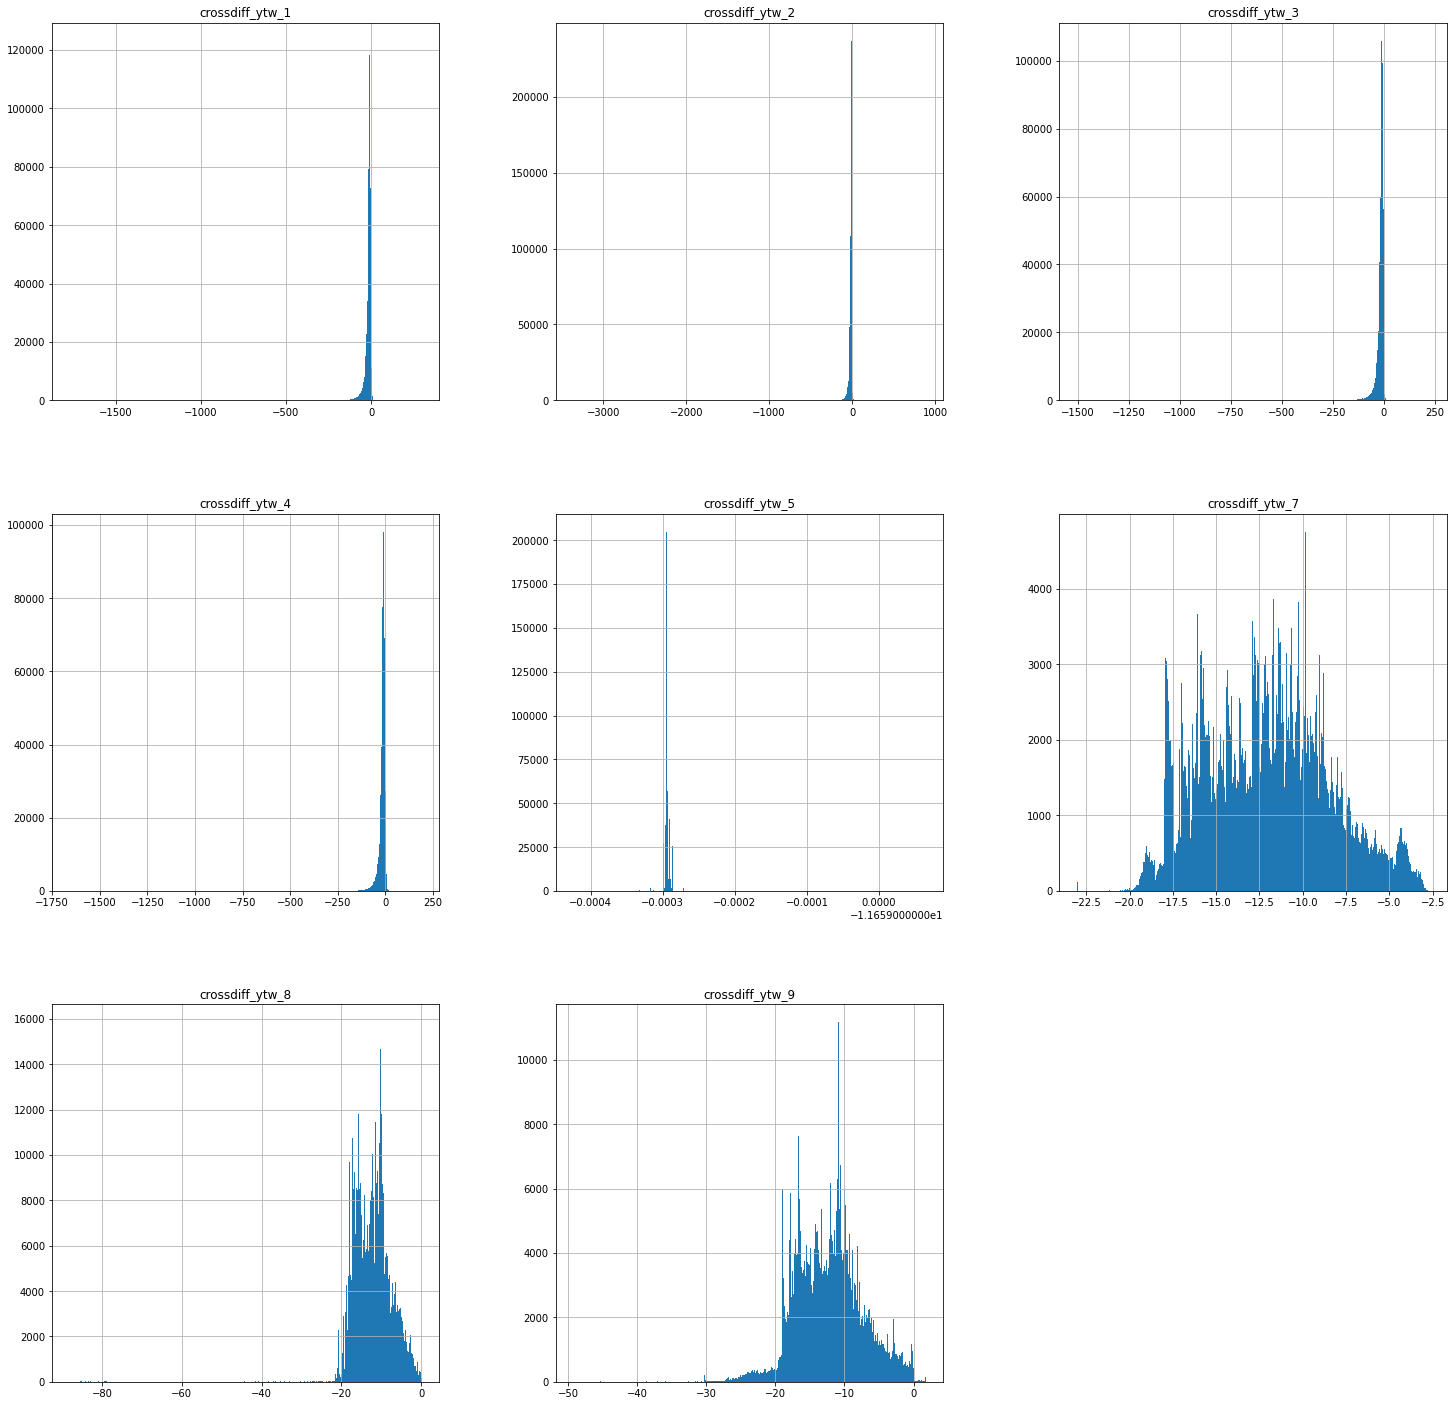

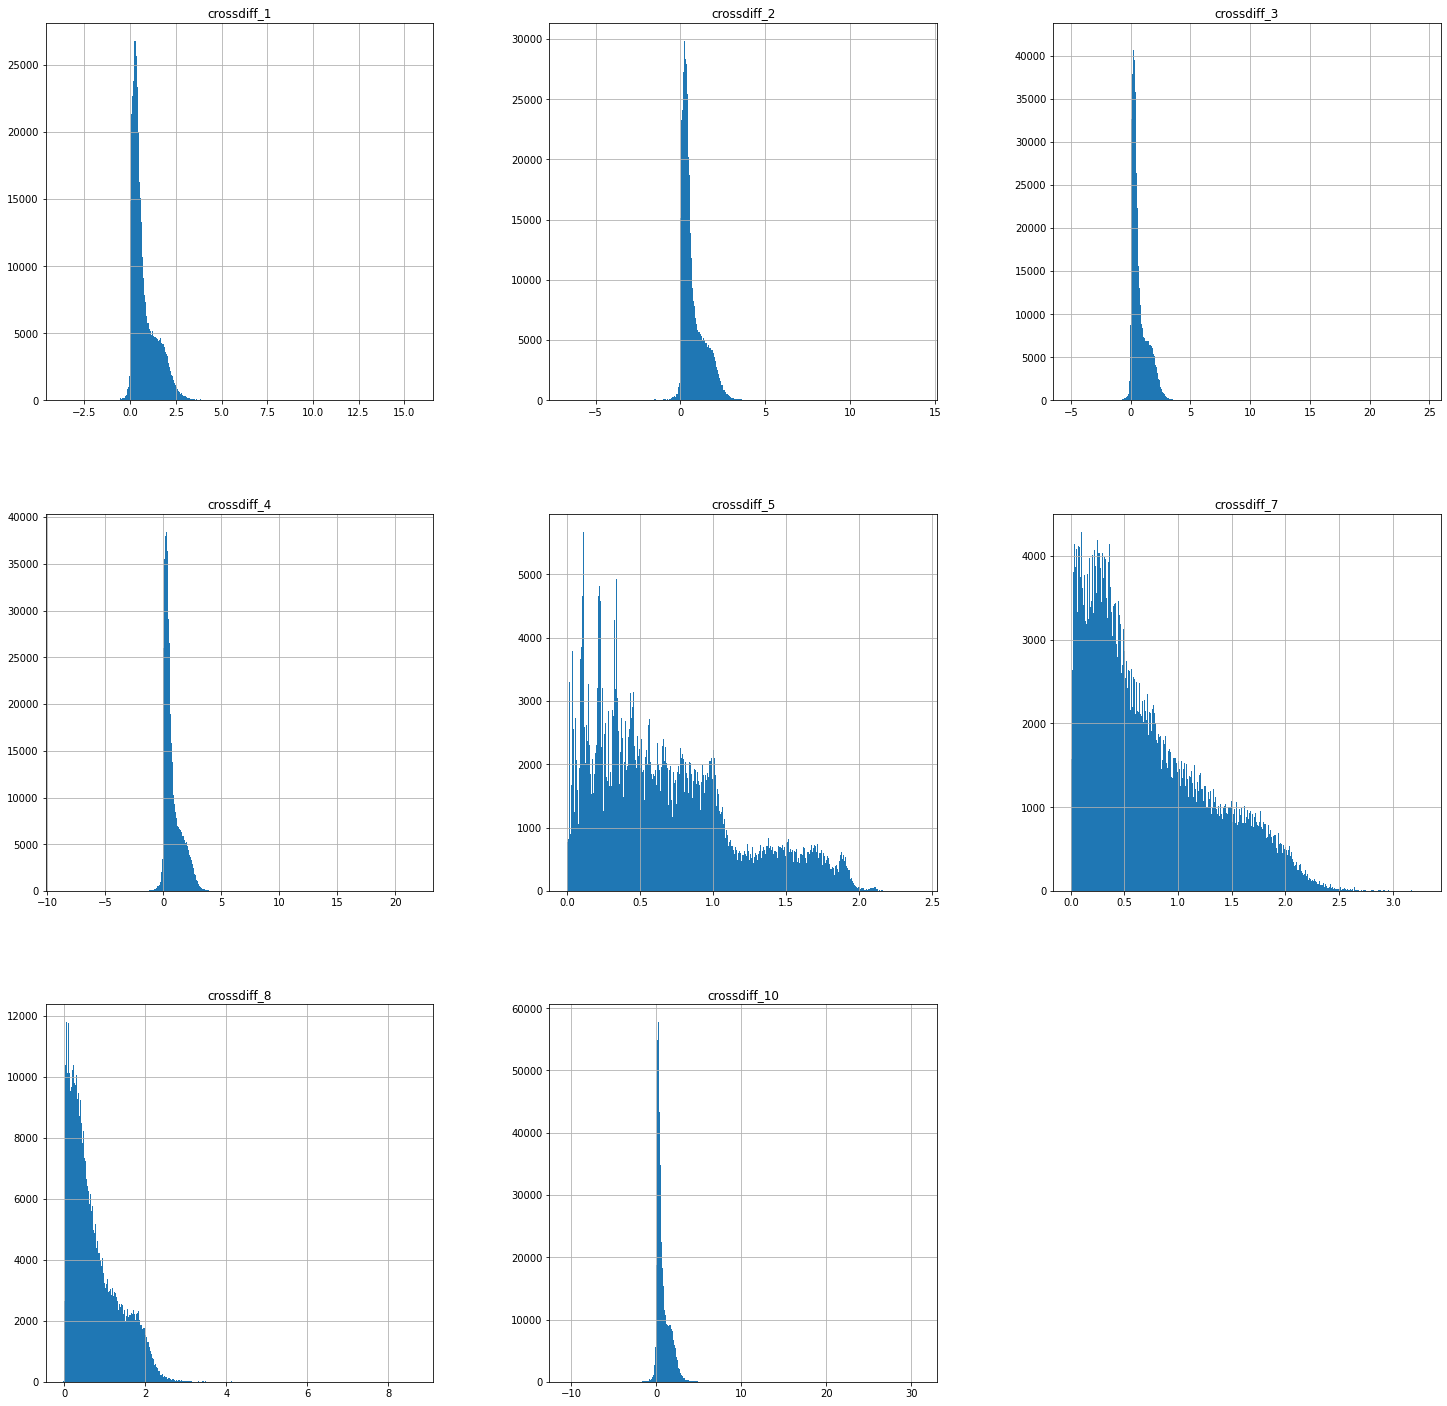

In [304]:
(cross_df.filter(regex='crossdiff_ytw_[1-9]+')*100).hist(bins=500, figsize=(25, 25));
cross_df.filter(regex='crossdiff_[1-9]+').hist(bins=500, figsize=(25, 25));

# 10: Evaluation:

9 different models were tested. The general trend is that moving trade_type and quantity to the model's final layers increases MAE slightly and reduces crossing predictions. To guarantee no crossing, at least in the dataset used here (train Feb-Jul, test first 2 weeks Aug) , the target trade type must be removed from the ttype features. This is because when the target trade type changes, the trade history derived ttypes features also change. Moving trade type to the end of the model is a simplification of the architecture that ensures non-linearity in the relationship between trade type and prediction is minimized, but having those trade type dependent features hinders the simplification.

Overall if we want to remove inversions entirely in model architecture, the quantifiable cost of doing so is less than 1 bps, probably around ~.6-.7bps. Model 5 and 6, New + no target ttype [1] and New + no target ttype [25, 1], both avoid producing any crossed predictions at all and the latter has slightly better accuracy and the added benefit of non-constant bid-ask spreads in yields. It is noteworthy that even though model 5 produces a constant spread in yield terms, the non-linear transformation of yield to price means that the bid-ask spread in dollar terms is non-constant.

In [321]:
cols = {'prediction_1': 'Default',
        'prediction_2': 'New [1]',
        'prediction_3': 'New Bottleneck [1]',
        'prediction_4': 'New [25, 1]',
        'prediction_5': 'New [50, 25, 1]',
        'prediction_6': 'New + no target ttype [1]',
        'prediction_7': 'New + no target ttype [25, 1]',
        'prediction_8': 'New + no target ttype [50, 25, 1]',
        'prediction_9': 'New + no ttype [50, 25]'
        }

In [335]:
summary = cross_df.filter(regex='cross_[1-9]+').sum()
summary.index = cols.values()
display(summary)

Default                              12932
New [1]                               9324
New Bottleneck [1]                   11542
New [25, 1]                          11390
New [50, 25, 1]                      20168
New + no target ttype [1]                0
New + no target ttype [25, 1]            0
New + no target ttype [50, 25, 1]      148
New + no ttype [50, 25]                786
dtype: int64

In [336]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction_1', 'prediction_2', 'prediction_3', 'prediction_4', 'prediction_5', 'prediction_6', 'prediction_7', 'prediction_8', 'prediction_9'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
summary = summary.rename(cols, axis=1)
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction_1', 'prediction_2', 'prediction_3', 'prediction_4', 'prediction_5', 'prediction_6', 'prediction_7', 'prediction_8', 'prediction_9'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
summary = summary.rename(cols, axis=1)
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_2 has 0 nan values
Prediction col prediction_3 has 0 nan values
Prediction col prediction_4 has 0 nan values
Prediction col prediction_5 has 0 nan values
Prediction col prediction_6 has 0 nan values
Prediction col prediction_7 has 0 nan values
Prediction col prediction_8 has 0 nan values
Prediction col prediction_9 has 0 nan values


MAE                             \
                                     Default New [1] New Bottleneck [1]   
Overall                               11.618  11.747             11.711   
1.5% <= last yld <= 7%                11.107  11.329             11.231   
1.5% <= last yld <= 7% & when issued   4.583   4.585              4.593   
last yld < 1.5%                       47.822  45.094             44.443   
last yld > 7%                        150.435 132.708            140.699   
no last yld                           40.076  40.074             39.746   
no last yld & when issued             13.990  13.933             15.265   
last yld > 7% & when issued            7.278   4.383              7.102   

                                                                  \
                                     New [25, 1] New [50, 25, 1]   
Overall                                   11.657          11.639   
1.5% <= last yld <= 7%                    11.226          11.169   
1.5% <= last yld <= 7% & when issued       4.813           4.701   
last yld < 1.5%                           44.979          44.406   
last yld > 7%                            135.255         137.705   
no last yld                               38.862          39.378   
no last yld & when issued                 13.535          14.842   
last yld > 7% & when issued                4.880           9.196   

                                                                \
                                     New + no target ttype [1]   
Overall                                                 12.443   
1.5% <= last yld <= 7%                                  11.982   
1.5% <= last yld <= 7% & when issued                     5.074   
last yld < 1.5%                                         45.231   
last yld > 7%                                          146.271   
no last yld                                             39.677   
no last yld & when issued                               15.452   
last yld > 7% & when issued                              8.300   

                                                                    \
                                     New + no target ttype [25, 1]   
Overall                                                     12.336   
1.5% <= last yld <= 7%                                      11.900   
1.5% <= last yld <= 7% & when issued                         5.045   
last yld < 1.5%                                             45.544   
last yld > 7%                                              142.054   
no last yld                                                 39.430   
no last yld & when issued                                   14.709   
last yld > 7% & when issued                                  9.173   

                                                                        \
                                     New + no target ttype [50, 25, 1]   
Overall                                                         12.190   
1.5% <= last yld <= 7%                                          11.754   
1.5% <= last yld <= 7% & when issued                             5.105   
last yld < 1.5%                                                 45.644   
last yld > 7%                                                  149.548   
no last yld                                                     38.480   
no last yld & when issued                                       13.286   
last yld > 7% & when issued                                     13.385   

                                                                 MAD          \
                                     New + no ttype [50, 25] Default New [1]   
Overall                                               12.195   5.837   6.035   
1.5% <= last yld <= 7%                                11.765   5.920   6.136   
1.5% <= last yld <= 7% & when issued                   5.136   3.005   3.017   
last yld < 1.5%                                       44.856  19.596  19.818   
last yld > 7%             

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_2 has 0 nan values
Prediction col prediction_3 has 0 nan values
Prediction col prediction_4 has 0 nan values
Prediction col prediction_5 has 0 nan values
Prediction col prediction_6 has 0 nan values
Prediction col prediction_7 has 0 nan values
Prediction col prediction_8 has 0 nan values
Prediction col prediction_9 has 0 nan values


MAE                             \
                                     Default New [1] New Bottleneck [1]   
Overall                                8.753   8.933              8.906   
1.5% <= last yld <= 7%                 8.698   8.900              8.814   
1.5% <= last yld <= 7% & when issued   4.470   4.470              4.477   
last yld < 1.5%                       18.055  18.971             18.810   
last yld > 7%                         62.651  57.866             64.101   
no last yld                           27.039  27.790             28.860   
no last yld & when issued             13.755  13.685             15.032   
last yld > 7% & when issued            7.278   4.383              7.102   

                                                                  \
                                     New [25, 1] New [50, 25, 1]   
Overall                                    8.875           8.852   
1.5% <= last yld <= 7%                     8.848           8.772   
1.5% <= last yld <= 7% & when issued       4.691           4.587   
last yld < 1.5%                           18.516          18.182   
last yld > 7%                             53.843          61.208   
no last yld                               26.347          27.059   
no last yld & when issued                 13.285          14.662   
last yld > 7% & when issued                4.880           9.196   

                                                                \
                                     New + no target ttype [1]   
Overall                                                  9.511   
1.5% <= last yld <= 7%                                   9.459   
1.5% <= last yld <= 7% & when issued                     4.946   
last yld < 1.5%                                         18.538   
last yld > 7%                                           59.397   
no last yld                                             27.296   
no last yld & when issued                               15.337   
last yld > 7% & when issued                              8.300   

                                                                    \
                                     New + no target ttype [25, 1]   
Overall                                                      9.418   
1.5% <= last yld <= 7%                                       9.393   
1.5% <= last yld <= 7% & when issued                         4.929   
last yld < 1.5%                                             17.965   
last yld > 7%                                               54.705   
no last yld                                                 27.407   
no last yld & when issued                                   14.452   
last yld > 7% & when issued                                  9.173   

                                                                        \
                                     New + no target ttype [50, 25, 1]   
Overall                                                          9.287   
1.5% <= last yld <= 7%                                           9.276   
1.5% <= last yld <= 7% & when issued                             4.977   
last yld < 1.5%                                                 18.131   
last yld > 7%                                                   63.843   
no last yld                                                     26.865   
no last yld & when issued                                       13.067   
last yld > 7% & when issued                                     13.385   

                                                                 MAD          \
                                     New + no ttype [50, 25] Default New [1]   
Overall                                                9.317   5.343   5.508   
1.5% <= last yld <= 7%                                 9.300   5.435   5.616   
1.5% <= last yld <= 7% & when issued                   5.016   2.988   3.004   
last yld < 1.5%                                       18.968  12.988  13.125   
last yld > 7%             

# Custom Model

The goal here is to build a model architecture that explicitly encapsulates the market dynamics between dealer-dealer, dealer-purchase and dealer-seller. While the main goal here is to train a model that naturally avoids crossing predictions, hypothetically such a model might also just be more accurate in general. That remains to be seen from the experiments below.

**Model Architecture**

The proposed model architecture has 2 sub models, sub-model 1 is responsible for predicting S trades and sub-model is responsible for predicting P trades. Dealer-dealer trades are taken as the average prediction of the two models. This architecture was chosen for a few reasons: 
- in being able to impose a penalty for crossing predictions, there needs to be two predictions for every S or P trade, which is the hypothetical opposite side of that same trade. There might be other ways of simulating this dual prediction task in the model, but an architecture with one model for each direction seems the most intuitive in understanding and in coding 
- having dealer-dealer as the average of the S and P trades has the theoretically appealing property of it always being the mid-market price. Assuming that the model has a sufficiently large penalty to prevent crossing, then the predictions will always have a semantic ordering with S>D>P.
- having two models in parallel in the model allows maximization of the GPU
- assuming we have a third model for dealer-dealer trades, these trades will not be involved in backpropogation for the S and P models, at least based on the way the loss function has been specified below

**The Loss Function**

The loss function is basically MAE with a penalty for crossing predictions. Because the model has three outputs, some modifications are required, namely indicator functions for which output to take in which case. $\lambda$ here refers to the scaling parameter for the cross penalty.

$$ L =  I(trade type=S)*(\hat{y_S} - y) + I(trade type=P)*(\hat{y_P} - y) + I(trade type=D)*(\frac{\hat{y_S} + \hat{y_P}}{2} - y)) + \lambda max(\hat{y_S} - \hat{y_P}, 0)*[I(trade type=P) + I(trade type=S)]$$

- Backpropagation for each trade type has different impact on each sub-model: 
    - S trade: S model directly through MAE, S and P model indirectly through cross penalty assuming S > P
    - P trade: P model directly through MAE, S and P model indirectly through cross penalty assuming S > P
    - D trade: S and P models directly through MAE

**Notes:**
1. The initial idea is to have two submodels, one corresponding to dealer-sells and the other to dealer-purchase. Dealer-dealer predictions will be made by taking the average of the two. However, accuracy on this appears to be poor when we successfully avoid crossing predictions, which is a penalty >= 24000. A few thoughts on this:
    - Perhaps dealer-dealer being the average of dealer sell and purchase, while parsimonious and theoretically appealling, is too rigid and it impedes model learning and accuracy. 
        - **CHANGE 1: let dealer-dealer be a weighted average of dealer purchase and sells, where the weights are learned**
    - Trade type is still being sent to the two submodels, and the information there is slightly muddled. For a dealer sells trade, for example, both the S and P model get an input of trade_type = 'S'. In backpropagation, even when we are evaluating an S trade the P model is still being influenced because of the penalty term. The inclusion of S might send confusing signals to the P model.  
        - **CHANGE 2: just remove trade_type from model inputs and use it at the final layer to triage prediction requests to either the S or P models.**
    - Currently, the penalty for the cross prediction is defined and calculated in the loss function, meaning that the penalty scaling is predefined when the model is instantiated. Idea inspired by Charles is to allow this penalty to be a learned parameter instead (?), which at worst will lead to a penalty scaling of 0. This might converge with current findings: there is a tradeoff between accuracy and the frequency of crossing when the penalty scale gets larger, and when it is equal to zero the 2 model architecture sometimes outperforms the single vanilla model. This is probably the most likely case, the model will simply discard the penalty term because that increases loss.
        - **CHANGE 3: rather than defining cross penalty in loss function, explicitly make it a model output with learned weights that is simply added in the loss function without any scaling. The scaling becomes implicit, dependent on the learned weights.**

In [17]:
dict(zip(encoders['trade_type'].classes_, encoders['trade_type'].transform(encoders['trade_type'].classes_)))

{'D': 0, 'P': 1, 'S': 2}

In [124]:
class CustomDecisionLayer(layers.Layer): 
    '''
    Custom layer that provides the correct output based on trade type.
    Has to take the trade_type input layer as an input as well.
    
    Notes:
    - this can be mounted on the model after training to make sure predictions have dimension 1, so no changes to model or server code needed
    '''
    def __init__(self):
        super().__init__()
    
    def call(self, inputs):
        trade_direction = inputs[:, 0]
        middle = (inputs[:, 1] + inputs[:, 2])/2
        
        S = tf.where(trade_direction == 2, inputs[:, 1], 0.0)
        P = tf.where(trade_direction == 1, inputs[:, 2], 0.0)
        D = tf.where(trade_direction == 0, middle, 0.0) 
        output = S + P + D
        return output

def CrossPenaltyLoss(penalty_scaling=None):
    '''
    Custom tf loss function that imposes a penalty from crossing predictions. 
    To take trade_type as an additional input we append trade_type to the actual output.
    This loss function requires a model that produces two outputs, with the assumption that output 1 is S and output 2 is P.
    '''
    if not penalty_scaling:
        penalty_scaling = 0.0 
        
    def loss(y_true, y_pred):
        trade_type = y_pred[:, 0]
        pred_S = y_pred[:, 1]
        pred_P = y_pred[:, 2]
        preds = (y_pred[:, 1] + y_pred[:, 2])/2

        #MAE
        preds = tf.where(trade_type == 1, pred_P, preds)
        preds = tf.where(trade_type == 2, pred_S, preds)

        #PENALTY
        penalty_S = tf.where(trade_type == 2, tf.maximum(0.0, pred_S - pred_P), 0.0)
        penalty_P = tf.where(trade_type == 1, tf.maximum(0.0, pred_S - pred_P), 0.0)

        return tf.reduce_mean(penalty_S + penalty_P)*penalty_scaling + keras.losses.MeanAbsoluteError()(y_true, preds)
    return loss


def CrossPenaltyLoss2(penalty_scaling=None):
    '''
    Same as CrossPenaltyLoss, but where dealer-dealer is not taken as the average but as a weighted average of S and P predictions with learned weights.
    This loss function requires a model that produces three outputs, with the assumption that output 1 is S and output 2 is P and output 3 is D.
    '''
    if not penalty_scaling:
        penalty_scaling = 0.0 
        
    def loss(y_true, y_pred):
        trade_type = y_pred[:, 0]
        pred_S = y_pred[:, 1]
        pred_P = y_pred[:, 2]
        pred_D = y_pred[:, 3]

        #MAE
        preds = pred_D
        preds = tf.where(trade_type == 1, pred_P, preds)
        preds = tf.where(trade_type == 2, pred_S, preds)
        
        #PENALTY
        penalty_S = tf.where(trade_type == 2, tf.maximum(0.0, pred_S - pred_P), 0.0)
        penalty_P = tf.where(trade_type == 1, tf.maximum(0.0, pred_S - pred_P), 0.0)

        return tf.reduce_mean(penalty_S + penalty_P)*penalty_scaling + keras.losses.MeanAbsoluteError()(y_true, preds)
    return loss

class CustomDecisionLayer2(layers.Layer): 
    '''Same as CustomDecisionLayer, but with D as an output, in addition to S and P.'''
    def __init__(self):
        super().__init__()
    
    def call(self, inputs):
        trade_direction = inputs[:, 0]
        
        S = tf.where(trade_direction == 2, inputs[:, 1], 0.0)
        P = tf.where(trade_direction == 1, inputs[:, 2], 0.0)
        D = tf.where(trade_direction == 0, inputs[:, 3], 0.0)
        output = S + P + D
        return output

In [19]:
reset_model_features()
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe,
                                                                                                         trade_history_col)

TRAINING DATA: N = 3768210, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
VALIDATION DATA: N = 418690, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
TEST DATA: N = 957385, MIN DATE = 2023-08-01 00:00:00, MAX DATE = 2023-08-31 00:00:00


2023-10-30 18:55:31.545620: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 18:55:31.573051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:55:31.576489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-30 18:55:31.579121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [20]:
fit_callbacks = [
keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True),
    ]

with tf.device('/cpu:0'):
    train_ds = create_tf_data(x_train, y_train, True, 0.75)
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
    val_ds = create_tf_data(x_val, y_val, shuffle = False)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()

## Pretrained sub-models
 
A crossing penalty of at least 24000 seems to be needed to prevent crossing, and this comes at the cost of around 1-2bps 

In [21]:
tf.keras.backend.clear_session()
gc.collect()

1575

In [22]:
TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
trade_history_normalizer = normalizers.get('trade_history_normalizer')
noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
BATCH_SIZE = 10000
LEARNING_RATE = 0.0007

# S_model = generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer) 
# P_model = generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer) 

S_model = keras.models.load_model('experiments/cross_market/new_ys_experiment_2023-10-16_14:26/model/model_0')
P_model = keras.models.load_model('experiments/cross_market/new_ys_experiment_2023-10-16_14:26/model/model_0')

S_model._name = 'S_model'
P_model._name = 'P_model'

input_layers = S_model.inputs 
trade_type_input_layer = [l for l in input_layers if l.name == 'trade_type'][0] #doing this to extract the trade_type input layer 

#INITIAL ARCHITECTURE 
outputs = layers.concatenate([trade_type_input_layer, S_model(input_layers), P_model(input_layers)])
CustomModel2 = keras.Model(inputs = input_layers, outputs = outputs)
CustomModel2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                    loss=CrossPenaltyLoss(penalty_scaling = 24000.0))

# ##CHANGE 1 ARCHITECTURE (see above) 
# D_output = layers.Dense(1, name='D_model')(layers.concatenate([S_model(input_layers), P_model(input_layers)]))
# outputs = layers.concatenate([trade_type_input_layer, S_model(input_layers), P_model(input_layers), D_output])
# CustomModel2 = keras.Model(inputs = input_layers, outputs = outputs)
# CustomModel2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
#                     loss=CrossPenaltyLoss2(penalty_scaling = 35000.0))

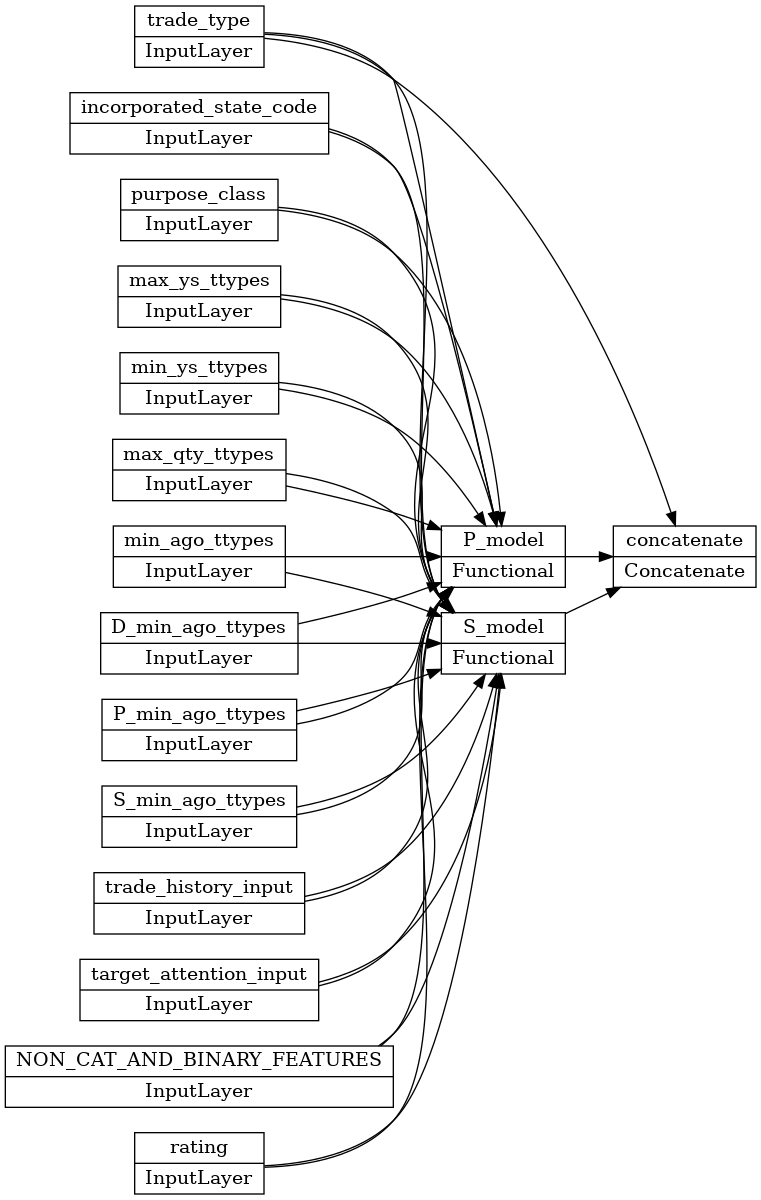

In [23]:
keras.utils.plot_model(CustomModel2, rankdir='LR')

In [633]:
# CustomModel2.save('pretrained_dual_model')

In [24]:
# cross_df.to_pickle('cross_df.pkl')
# test_dataframe.to_pickle('test_dataframe.pkl')

cross_df = pd.read_pickle('cross_df.pkl')
test_dataframe = pd.read_pickle('test_dataframe.pkl')

In [25]:
history = CustomModel2.fit(train_ds,
                                  validation_data=val_ds,
                                    epochs=200,     
                                    verbose=1, 
                                    callbacks=fit_callbacks,
                                    use_multiprocessing=True,
                                    workers=8)

Epoch 1/200


2023-10-30 19:04:42.317196: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-30 19:04:42.317425: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

377/377 [==============================] - ETA: 0s - loss: 893.2427

2023-10-30 19:08:28.533758: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-30 19:08:28.533910: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

377/377 [==============================] - 249s 452ms/step - loss: 893.2427 - val_loss: 17.0055
Epoch 2/200
377/377 [==============================] - 54s 144ms/step - loss: 26.4327 - val_loss: 17.4987
Epoch 3/200
106/377 [=======>......................] - ETA: 36s - loss: 20.7382

KeyboardInterrupt: 

In [649]:
CustomModel2.layers[-2].weights

[<tf.Variable 'D_model/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[0.6071777 ],
        [0.43513772]], dtype=float32)>,
 <tf.Variable 'D_model/bias:0' shape=(1,) dtype=float32, numpy=array([-0.6978107], dtype=float32)>]

In [733]:
new_output = CustomDecisionLayer()(outputs)
NewCustomModel = keras.Model(inputs = input_layers, outputs = new_output)
test_dataframe['prediction_10'] = NewCustomModel.predict(x_test, batch_size=10000)

2023-10-30 17:38:07.894422: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-30 17:38:07.894956: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

In [734]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction_1', 'prediction_10'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction_1',  'prediction_10'],   
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_10 has 0 nan values


MAE                        MAD  \
                                     prediction_1 prediction_10 prediction_1   
Overall                                    11.618        13.388        5.837   
1.5% <= last yld <= 7%                     11.107        12.634        5.920   
1.5% <= last yld <= 7% & when issued        4.583         6.519        3.005   
last yld < 1.5%                            47.822        54.131       19.596   
last yld > 7%                             150.435       166.052       33.916   
no last yld                                40.076        45.354       18.166   
no last yld & when issued                  13.990        20.357       10.402   
last yld > 7% & when issued                 7.278        45.508        4.697   

                                                            
                                     prediction_10       N  
Overall                                      7.492  957385  
1.5% <= last yld <= 7%                       7.526  866005  
1.5% <= last yld <= 7% & when issued         4.375   53088  
last yld < 1.5%                             23.247    5937  
last yld > 7%                               51.650    2877  
no last yld                                 23.682    5082  
no last yld & when issued                   12.870   24258  
last yld > 7% & when issued                 44.566     138

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_10 has 0 nan values


MAE                        MAD  \
                                     prediction_1 prediction_10 prediction_1   
Overall                                     8.753        10.451        5.343   
1.5% <= last yld <= 7%                      8.698        10.150        5.435   
1.5% <= last yld <= 7% & when issued        4.470         6.413        2.988   
last yld < 1.5%                            18.055        25.612       12.988   
last yld > 7%                              62.651        85.348       16.834   
no last yld                                27.039        32.996       15.906   
no last yld & when issued                  13.755        20.105       10.320   
last yld > 7% & when issued                 7.278        45.508        4.697   

                                                            
                                     prediction_10       N  
Overall                                      6.915  817903  
1.5% <= last yld <= 7%                       6.963  734841  
1.5% <= last yld <= 7% & when issued         4.360   51967  
last yld < 1.5%                             17.218    3131  
last yld > 7%                               36.832    1030  
no last yld                                 21.810    3343  
no last yld & when issued                   12.775   23453  
last yld > 7% & when issued                 44.566     138

In [735]:
x_cross = create_input(cross_df, trade_history_col)
preds = NewCustomModel.predict(x_cross, batch_size=10000)
cross_df['predicted_ytw_10'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

In [743]:
tf.keras.backend.clear_session()
gc.collect()

160

In [744]:
%time cross_df['predicted_dp_10'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_10']), axis = 1))
%time diffs = check_cross_diff_fast(cross_df, 'predicted_dp_10').to_dict()
%time cross_df['crossdiff_10'] = cross_df['id'].parallel_apply(diffs.get)
%time diffs = check_cross_diff_fast(cross_df, 'predicted_ytw_10').to_dict()
%time cross_df['crossdiff_ytw_10'] = cross_df['id'].parallel_apply(diffs.get)

OSError: [Errno 12] Cannot allocate memory

CPU times: user 1.8 s, sys: 73.1 ms, total: 1.87 s
Wall time: 2.26 s


OSError: [Errno 12] Cannot allocate memory

CPU times: user 1.84 s, sys: 0 ns, total: 1.84 s
Wall time: 1.84 s


OSError: [Errno 12] Cannot allocate memory

In [742]:
sum(cross_df['crossdiff_10'] < 0)/len(cross_df) * 100

2.6722863159042434

In [ ]:
sum(cross_df['crossdiff_ytw_10'] > 0 )

In [435]:
sum(cross_df['crossdiff_1'] < 0)/len(cross_df) * 100

1.588448145447607

## Implementing Change 2:

In [656]:
#input functions are changed to append trade_type at the end rather than with the other categorical inputs
def create_input_3(df, trade_history_col):
    global encoders
    datalist = []
    
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    for f in ['trade_type']:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
        
    return datalist

def create_data_set_and_model_3(train_dataframe, test_dataframe, trade_history_col):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH}
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_3(train_dataframe.drop(val_idx, axis=0), trade_history_col)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_3(train_dataframe.iloc[val_idx], trade_history_col)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_3(test_dataframe, trade_history_col)
    y_test = test_dataframe[target_variable]    
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx

In [676]:
#we no longer want trade type as a predictor 
modify_features(['trade_type'], 'remove', 'categorical')
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_3(train_dataframe, 
                                                                                                         test_dataframe,
                                                                                                         trade_history_col)

TRAINING DATA: N = 3768210, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
VALIDATION DATA: N = 418690, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
TEST DATA: N = 957385, MIN DATE = 2023-08-01 00:00:00, MAX DATE = 2023-08-31 00:00:00


In [677]:
train_ds = create_tf_data(x_train, y_train, True, 0.75)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
val_ds = create_tf_data(x_val, y_val, shuffle = False)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()

In [718]:
S_model = generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer) 
P_model = generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer) 

S_model._name = 'S_model'
P_model._name = 'P_model'

input_layers = S_model.inputs 
trade_type_input_layer = layers.Input(shape=(1,), name = 'trade_type')

##INITIAL ARCHITECTURE 
outputs = layers.concatenate([trade_type_input_layer, S_model(input_layers), P_model(input_layers)])
# ##CHANGE 1 ARCHITECTURE (see above) 
# D_output = layers.Dense(1)(layers.concatenate([S_model(input_layers), P_model(input_layers)]))
# outputs = layers.concatenate([trade_type_input_layer, S_model(input_layers), P_model(input_layers), D_output])

input_layers = input_layers + [trade_type_input_layer]
CustomModel2 = keras.Model(inputs = input_layers, outputs = outputs)

CustomModel2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                    loss=CrossPenaltyLoss(penalty_scaling = 40000.0))

In [719]:
history = CustomModel2.fit(train_ds,
                                  validation_data=val_ds,
                                    epochs=200,     
                                    verbose=1, 
                                    callbacks=fit_callbacks,
                                    use_multiprocessing=True,
                                    workers=8)

Epoch 1/200


2023-10-28 22:17:43.415224: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-28 22:17:43.415429: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

377/377 [==============================] - ETA: 0s - loss: 283.0000

2023-10-28 22:18:38.719469: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-28 22:18:38.719600: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

377/377 [==============================] - 76s 148ms/step - loss: 283.0000 - val_loss: 55.7597
Epoch 2/200
377/377 [==============================] - 53s 141ms/step - loss: 56.0863 - val_loss: 55.7451
Epoch 3/200
377/377 [==============================] - 54s 144ms/step - loss: 55.9715 - val_loss: 55.6125
Epoch 4/200
377/377 [==============================] - 53s 142ms/step - loss: 55.8267 - val_loss: 55.4447
Epoch 5/200
377/377 [==============================] - 54s 144ms/step - loss: 55.6302 - val_loss: 55.2094
Epoch 6/200
377/377 [==============================] - 54s 143ms/step - loss: 55.3660 - val_loss: 54.8912
Epoch 7/200
377/377 [==============================] - 54s 143ms/step - loss: 54.9983 - val_loss: 54.4458
Epoch 8/200
377/377 [==============================] - 53s 142ms/step - loss: 54.4938 - val_loss: 53.8513
Epoch 9/200
377/377 [==============================] - 55s 145ms/step - loss: 54.0239 - val_loss: 53.2903
Epoch 10/200
377/377 [==============================] - 5

In [ ]:
keras.utils.plot_model(CustomModel2)

In [720]:
new_output = CustomDecisionLayer()(outputs)
NewCustomModel = keras.Model(inputs = input_layers, outputs = new_output)
test_dataframe['prediction_10'] = NewCustomModel.predict(x_test, batch_size=10000)

2023-10-28 23:21:22.632537: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-28 23:21:22.632676: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

In [721]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction_1', 'prediction_10'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction_1',  'prediction_10'],   
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_10 has 0 nan values


MAE                        MAD  \
                                     prediction_1 prediction_10 prediction_1   
Overall                                    11.618        13.459        5.837   
1.5% <= last yld <= 7%                     11.107        12.647        5.920   
1.5% <= last yld <= 7% & when issued        4.583         6.420        3.005   
last yld < 1.5%                            47.822        60.615       19.596   
last yld > 7%                             150.435       173.433       33.916   
no last yld                                40.076        48.031       18.166   
no last yld & when issued                  13.990        19.951       10.402   
last yld > 7% & when issued                 7.278        39.256        4.697   

                                                            
                                     prediction_10       N  
Overall                                      7.162  957385  
1.5% <= last yld <= 7%                       7.188  866005  
1.5% <= last yld <= 7% & when issued         4.271   53088  
last yld < 1.5%                             27.766    5937  
last yld > 7%                               53.217    2877  
no last yld                                 24.946    5082  
no last yld & when issued                   11.761   24258  
last yld > 7% & when issued                 33.633     138

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_10 has 0 nan values


MAE                        MAD  \
                                     prediction_1 prediction_10 prediction_1   
Overall                                     8.753        10.333        5.343   
1.5% <= last yld <= 7%                      8.698         9.970        5.435   
1.5% <= last yld <= 7% & when issued        4.470         6.293        2.988   
last yld < 1.5%                            18.055        35.861       12.988   
last yld > 7%                              62.651        92.458       16.834   
no last yld                                27.039        37.333       15.906   
no last yld & when issued                  13.755        19.631       10.320   
last yld > 7% & when issued                 7.278        39.256        4.697   

                                                            
                                     prediction_10       N  
Overall                                      6.549  817903  
1.5% <= last yld <= 7%                       6.584  734841  
1.5% <= last yld <= 7% & when issued         4.247   51967  
last yld < 1.5%                             19.703    3131  
last yld > 7%                               26.581    1030  
no last yld                                 22.823    3343  
no last yld & when issued                   11.651   23453  
last yld > 7% & when issued                 33.633     138

In [722]:
x_cross = create_input_3(cross_df, trade_history_col)
preds = NewCustomModel.predict(x_cross, batch_size=10000)
cross_df['predicted_ytw_10'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

In [723]:
tf.keras.backend.clear_session()
gc.collect()

178890

In [724]:
%time cross_df['predicted_dp_10'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_10']), axis = 1))
%time diffs = check_cross_diff_fast(cross_df, 'predicted_dp_10').to_dict()
%time cross_df['crossdiff_10'] = cross_df['id'].parallel_apply(diffs.get)
%time diffs = check_cross_diff_fast(cross_df, 'predicted_ytw_10').to_dict()
%time cross_df['crossdiff_ytw_10'] = cross_df['id'].parallel_apply(diffs.get)

CPU times: user 11.5 s, sys: 13.1 s, total: 24.6 s
Wall time: 1min 38s
CPU times: user 3.89 s, sys: 0 ns, total: 3.89 s
Wall time: 4.13 s
CPU times: user 12.1 s, sys: 11.7 s, total: 23.8 s
Wall time: 25.8 s
CPU times: user 1.37 s, sys: 453 ms, total: 1.83 s
Wall time: 1.82 s
CPU times: user 14.6 s, sys: 17.3 s, total: 31.9 s
Wall time: 33.8 s


In [726]:
sum(cross_df['crossdiff_10'] < 0)/len(cross_df) * 100

2.6722863159042434

## Implementing Non-Cross Architecture:

In [125]:
reset_model_features()
# modify_features(['quantity'], 'remove', 'numeric')
# modify_features(['trade_type'], 'remove', 'categorical')

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model_2(train_dataframe2, 
                                                                                                         test_dataframe2, 
                                                                                                         trade_history_col)

TRAINING DATA: N = 3768210, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
VALIDATION DATA: N = 418690, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-07-31 00:00:00
TEST DATA: N = 957385, MIN DATE = 2023-08-01 00:00:00, MAX DATE = 2023-08-31 00:00:00


In [128]:
fit_callbacks = [
keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True),
    ]

with tf.device('/cpu:0'):
    train_ds = create_tf_data(x_train, y_train, True, 0.75)
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
    val_ds = create_tf_data(x_val, y_val, shuffle = False)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()

In [155]:
TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
trade_history_normalizer = normalizers.get('trade_history_normalizer')
noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
BATCH_SIZE = 10000
LEARNING_RATE = 0.0007

# S_model = generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer) 
# P_model = generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer) 

S_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_13:34/model/model_0')
P_model = keras.models.load_model('experiments/cross_market_ttype_qty_architecture_removed_ttypes/new_ys_experiment_2023-10-31_13:34/model/model_0')

S_model._name = 'S_model'
P_model._name = 'P_model'

input_layers = S_model.inputs 
trade_type_input_layer = [l for l in input_layers if l.name == 'trade_type'][0] #doing this to extract the trade_type input layer 

#INITIAL ARCHITECTURE 
outputs = layers.concatenate([trade_type_input_layer, S_model(input_layers), P_model(input_layers)])
CustomModel2 = keras.Model(inputs = input_layers, outputs = outputs)
CustomModel2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                    loss=CrossPenaltyLoss(penalty_scaling = 40000.0))

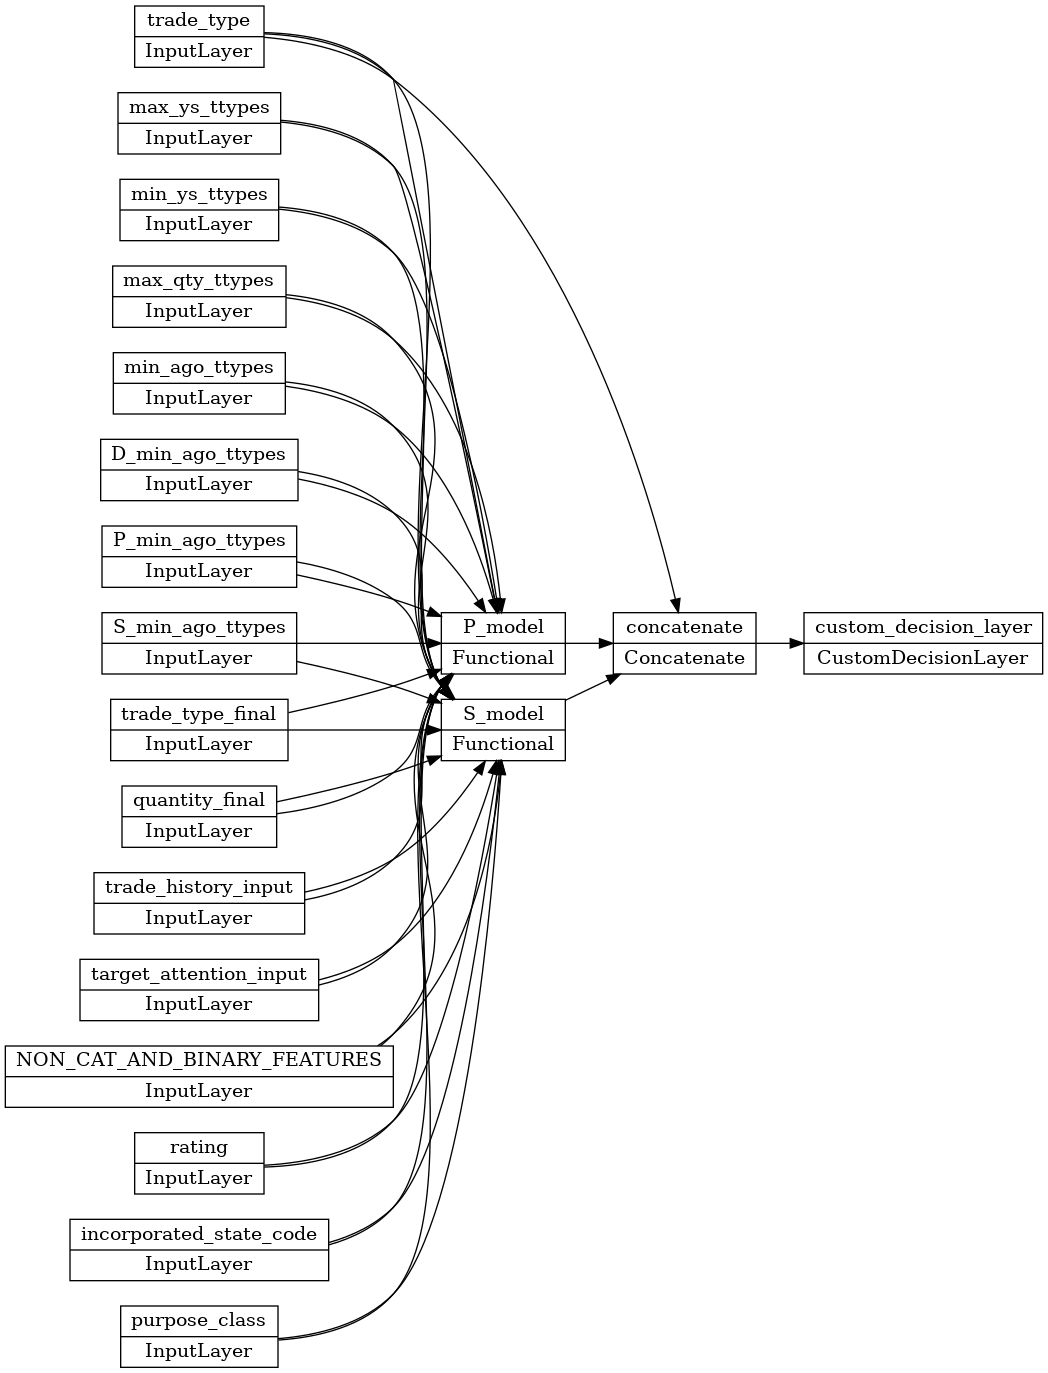

In [156]:
keras.utils.plot_model(NewCustomModel, rankdir='LR')

In [157]:
history = CustomModel2.fit(train_ds,
                                  validation_data=val_ds,
                                    epochs=200,     
                                    verbose=1, 
                                    callbacks=fit_callbacks,
                                    use_multiprocessing=True,
                                    workers=8)

Epoch 1/200


2023-11-02 00:14:33.184729: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-02 00:14:33.184906: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

377/377 [==============================] - ETA: 0s - loss: 1031.5884

2023-11-02 00:15:33.164804: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-02 00:15:33.164958: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

377/377 [==============================] - 78s 161ms/step - loss: 1031.5884 - val_loss: 14.8858
Epoch 2/200
377/377 [==============================] - 56s 150ms/step - loss: 21.9107 - val_loss: 15.2160
Epoch 3/200
377/377 [==============================] - 56s 150ms/step - loss: 18.1535 - val_loss: 15.2825
Epoch 4/200
377/377 [==============================] - 56s 150ms/step - loss: 16.3907 - val_loss: 15.1779
Epoch 5/200
377/377 [==============================] - 57s 150ms/step - loss: 16.2827 - val_loss: 15.2736
Epoch 6/200
377/377 [==============================] - 56s 150ms/step - loss: 16.4926 - val_loss: 15.3495
Epoch 7/200
377/377 [==============================] - 57s 151ms/step - loss: 16.0865 - val_loss: 15.0306
Epoch 8/200
377/377 [==============================] - 56s 150ms/step - loss: 18.2476 - val_loss: 15.2779
Epoch 9/200
377/377 [==============================] - 57s 150ms/step - loss: 16.0349 - val_loss: 15.1814
Epoch 10/200
377/377 [==============================] - 

In [158]:
new_output = CustomDecisionLayer()(outputs)
NewCustomModel = keras.Model(inputs = input_layers, outputs = new_output)
test_dataframe['prediction_10'] = NewCustomModel.predict(x_test, batch_size=10000)

2023-11-02 06:15:49.667517: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-11-02 06:15:49.667704: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

In [159]:
summary = compare_mae(df=test_dataframe, 
                          prediction_cols = ['prediction_1', 'prediction_10'], 
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

summary = compare_mae(df=test_dataframe[short_filter], 
                          prediction_cols = ['prediction_1',  'prediction_10'],   
                          groupby_cols = None,
                      target_variable='new_ys'
                         )
display(summary)

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_10 has 0 nan values


MAE                        MAD  \
                                     prediction_1 prediction_10 prediction_1   
Overall                                    11.618        13.997        5.837   
1.5% <= last yld <= 7%                     11.107        13.329        5.920   
1.5% <= last yld <= 7% & when issued        4.583         7.203        3.005   
last yld < 1.5%                            47.822        52.450       19.596   
last yld > 7%                             150.435       167.194       33.916   
no last yld                                40.076        51.899       18.166   
no last yld & when issued                  13.990        16.971       10.402   
last yld > 7% & when issued                 7.278        49.677        4.697   

                                                            
                                     prediction_10       N  
Overall                                      8.187  957385  
1.5% <= last yld <= 7%                       8.249  866005  
1.5% <= last yld <= 7% & when issued         4.982   53088  
last yld < 1.5%                             27.487    5937  
last yld > 7%                               57.576    2877  
no last yld                                 27.412    5082  
no last yld & when issued                   11.254   24258  
last yld > 7% & when issued                 45.988     138

======================= Analysis for target: new_ys =======================
Prediction col prediction_1 has 0 nan values
Prediction col prediction_10 has 0 nan values


MAE                        MAD  \
                                     prediction_1 prediction_10 prediction_1   
Overall                                     8.753        11.048        5.343   
1.5% <= last yld <= 7%                      8.698        10.852        5.435   
1.5% <= last yld <= 7% & when issued        4.470         7.088        2.988   
last yld < 1.5%                            18.055        27.270       12.988   
last yld > 7%                              62.651        85.067       16.834   
no last yld                                27.039        35.969       15.906   
no last yld & when issued                  13.755        16.772       10.320   
last yld > 7% & when issued                 7.278        49.677        4.697   

                                                            
                                     prediction_10       N  
Overall                                      7.569  817903  
1.5% <= last yld <= 7%                       7.646  734841  
1.5% <= last yld <= 7% & when issued         4.924   51967  
last yld < 1.5%                             21.582    3131  
last yld > 7%                               41.082    1030  
no last yld                                 25.094    3343  
no last yld & when issued                   11.233   23453  
last yld > 7% & when issued                 45.988     138

In [160]:
x_cross = create_input_2(cross_df2, trade_history_col)
preds = NewCustomModel.predict(x_cross, batch_size=10000)
cross_df['predicted_ytw_10'] = (preds.reshape(-1,) + cross_df['new_ficc_ycl'].values)/100

In [161]:
tf.keras.backend.clear_session()
gc.collect()

899951

In [162]:
%time cross_df['predicted_dp_10'], _ = zip(*cross_df.parallel_apply(lambda x: compute_price(x, x['predicted_ytw_10']), axis = 1))
%time diffs = check_cross_diff_fast(cross_df, 'predicted_dp_10').to_dict()
%time cross_df['crossdiff_10'] = cross_df['id'].parallel_apply(diffs.get)
%time diffs = check_cross_diff_fast(cross_df, 'predicted_ytw_10').to_dict()
%time cross_df['crossdiff_ytw_10'] = cross_df['id'].parallel_apply(diffs.get)

CPU times: user 16.5 s, sys: 10.2 s, total: 26.8 s
Wall time: 1min 34s
CPU times: user 1.76 s, sys: 0 ns, total: 1.76 s
Wall time: 1.75 s
CPU times: user 11.2 s, sys: 11.4 s, total: 22.6 s
Wall time: 25.7 s
CPU times: user 3.78 s, sys: 9.72 ms, total: 3.79 s
Wall time: 3.84 s
CPU times: user 12.9 s, sys: 8.19 s, total: 21.1 s
Wall time: 22.4 s


In [163]:
sum(cross_df['crossdiff_10'] < 0)/len(cross_df) * 100

0.0